In [1]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
import numpy as np
import pandas as pd
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline 

/home/ejrueda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Esquema de una GANs
- Generator: es la red que se encarga de producir imágenes falsas, para tratar de engañar al discriminador.
- Discriminator: recibe imágenes falsas y reales, y se entrena para que pueda predecir la autencicidad de cada una.

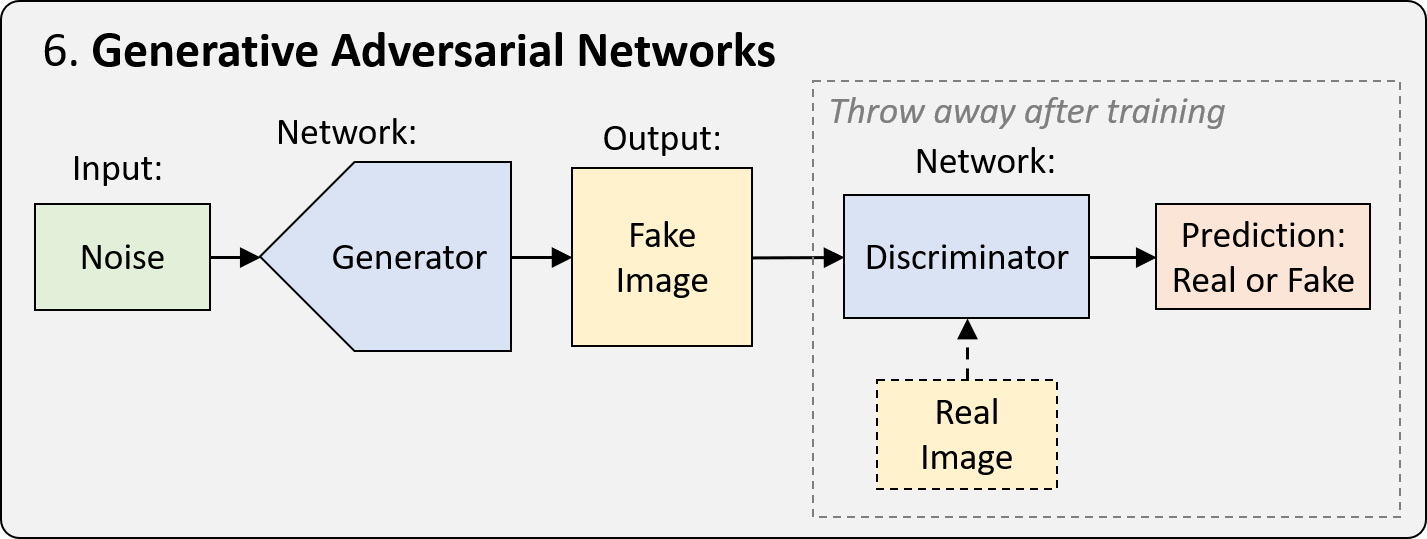

In [2]:
from IPython.display import Image
Image(filename="GANs_arquitectura.png")

#### Se carga el MNIST con el que se va a probar la arquitectura.

In [3]:
data_train = pd.read_csv("./data/train.csv")
data_test = pd.read_csv("./data/test.csv")
data_train.shape, data_test.shape

((42000, 785), (28000, 784))

In [4]:
data_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


-- Imágenes originales --


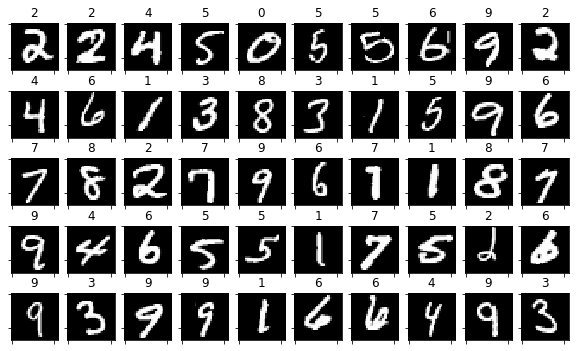

In [5]:
num_imgs = 50 #número de imágenes a mostrar aleatoriamente
fig = plt.figure(figsize=(10,6))
print("-- Imágenes originales --")
for i in range(num_imgs):
    ax=fig.add_subplot(5,10,i+1)
    rdm_img = np.random.randint(1,data_train.shape[0]-1)
    plt.imshow(np.array(data_train.iloc[rdm_img,1:]).reshape(28,28), cmap = plt.cm.Greys_r)
    ax.set_title(int(data_train.iloc[rdm_img,0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Ejemplo del generador de ruido:
- se generan imágenes a partir de una distribución gausiana, para con ellas estimar la nuevas imágenes.

In [10]:
#se crea el modelo secuencial el cual hará las veces de generador de ruido
model = Sequential()
model.add(Dense(256, input_shape=(100,)))
model.add(LeakyReLU(alpha=0.2)) #función rectificadora
model.add(Dropout(0.1))
model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(Dropout(0.1))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(28  * 28 * 1, activation='tanh'))
model.add(Reshape((28, 28, 1)))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5, decay=8e-8))

In [11]:
#model.summary()
batch = 640
gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
syntetic_images = model.predict(gen_noise)
print("Imágenes: ",syntetic_images.shape)

Imágenes:  (320, 28, 28, 1)


imágenes que genera el modelo


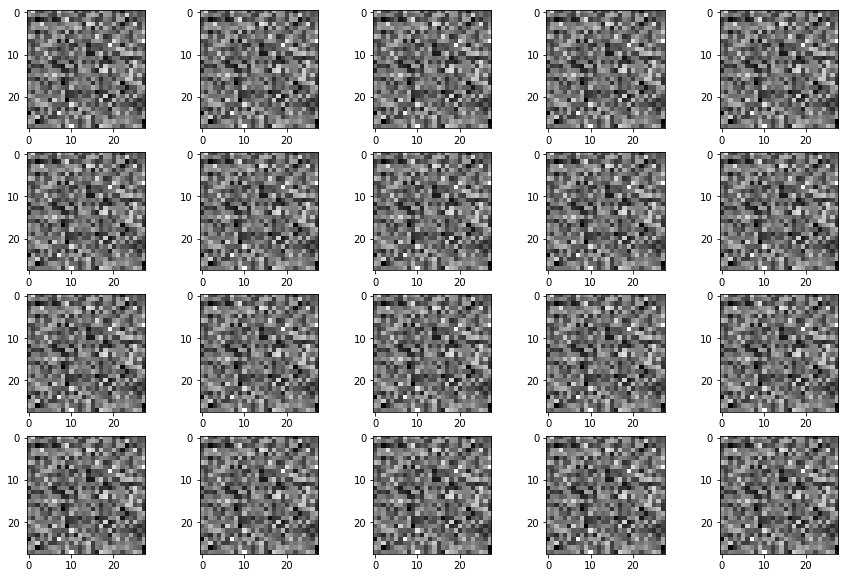

In [12]:
num_imgs = 20
plt.figure(figsize=(15,10))
print("imágenes que genera el modelo")
for i in range(num_imgs):
    plt.subplot(4,5,i+1)
    img_idx = np.random.randint(0,syntetic_images.shape[0])
    plt.imshow(syntetic_images[0,:,:].reshape(28,28), cmap="gray")

## Generative Adversarial Networks - GANs
- Se crea una clase llamada "GANs" y en ella se define tanto el generador como el discriminador, tambien el método para unir los dos modelos "__stacked_generator_discriminator". Por último se crea el método train el cual entrena la red.

In [6]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=28, height=28, channels=1):
        #para retornar las imágenes
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        #model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        Imgs = []
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            #print(random_index)
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_images = self.G.predict(gen_noise)
            #print(legit_images.shape, syntetic_images.shape)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            #bined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            if (cnt % 100) ==0: #para dibujar solos módulos de 100
                Imgs.append(self.plot_images(save2file=True, samples=20, step=cnt))
                print(np.array(Imgs).shape)
        return Imgs
            
    def plot_images(self, save2file=False, samples=20, step=0):
        # Para pintar o guardar las imágenes
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_" + str(step) + ".png"
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)
        #print(images.shape)
        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 5, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.HEIGHT, self.WIDTH])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
        return images

In [7]:
#X_train = np.array(data_train.iloc[:,1:])
#y_train = np.array(data_train.iloc[:,0])

#Para generar solo números 8
X_train = np.array(data_train.loc[data_train["label"]==4].iloc[:,1:])
y_train = np.array(data_train.loc[data_train["label"]==4].iloc[:,0])

In [8]:
m = 255/2
X_train = (X_train.astype(np.float32) - m) / m
X_train = np.expand_dims(X_train, axis=3)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#np.expand_dims - Para expandir las dimensiones de un array

In [10]:
gan = GANs()
l_img = gan.train(X_train,epochs=10000,batch=128)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 0.565082], [ Generator :: loss: 0.723298]
(1, 20, 28, 28, 1)
epoch: 1, [Discriminator :: d_loss: 0.455491], [ Generator :: loss: 0.774169]
epoch: 2, [Discriminator :: d_loss: 0.372747], [ Generator :: loss: 0.798423]
epoch: 3, [Discriminator :: d_loss: 0.339544], [ Generator :: loss: 0.912225]
epoch: 4, [Discriminator :: d_loss: 0.308769], [ Generator :: loss: 1.004305]
epoch: 5, [Discriminator :: d_loss: 0.270742], [ Generator :: loss: 1.125978]
epoch: 6, [Discriminator :: d_loss: 0.222868], [ Generator :: loss: 1.278941]
epoch: 7, [Discriminator :: d_loss: 0.207809], [ Generator :: loss: 1.351700]
epoch: 8, [Discriminator :: d_loss: 0.173850], [ Generator :: loss: 1.436179]
epoch: 9, [Discriminator :: d_loss: 0.162590], [ Generator :: loss: 1.530894]
epoch: 10, [Discriminator :: d_loss: 0.157149], [ Generator :: loss: 1.612190]
epoch: 11, [Discriminator :: d_loss: 0.141294], [ Generator :: loss: 1.750486]
epoch: 12, [Discriminator :: d_loss: 0.1177

epoch: 106, [Discriminator :: d_loss: 0.014850], [ Generator :: loss: 4.172953]
epoch: 107, [Discriminator :: d_loss: 0.014012], [ Generator :: loss: 4.207106]
epoch: 108, [Discriminator :: d_loss: 0.014243], [ Generator :: loss: 4.294378]
epoch: 109, [Discriminator :: d_loss: 0.013108], [ Generator :: loss: 4.254636]
epoch: 110, [Discriminator :: d_loss: 0.013588], [ Generator :: loss: 4.211549]
epoch: 111, [Discriminator :: d_loss: 0.012593], [ Generator :: loss: 4.299133]
epoch: 112, [Discriminator :: d_loss: 0.014957], [ Generator :: loss: 4.194610]
epoch: 113, [Discriminator :: d_loss: 0.013202], [ Generator :: loss: 4.272470]
epoch: 114, [Discriminator :: d_loss: 0.016226], [ Generator :: loss: 4.263956]
epoch: 115, [Discriminator :: d_loss: 0.011060], [ Generator :: loss: 4.261868]
epoch: 116, [Discriminator :: d_loss: 0.019045], [ Generator :: loss: 4.251218]
epoch: 117, [Discriminator :: d_loss: 0.015124], [ Generator :: loss: 4.294632]
epoch: 118, [Discriminator :: d_loss: 0.

epoch: 210, [Discriminator :: d_loss: 0.056527], [ Generator :: loss: 3.888350]
epoch: 211, [Discriminator :: d_loss: 0.056293], [ Generator :: loss: 3.649623]
epoch: 212, [Discriminator :: d_loss: 0.069757], [ Generator :: loss: 3.906568]
epoch: 213, [Discriminator :: d_loss: 0.117857], [ Generator :: loss: 3.740330]
epoch: 214, [Discriminator :: d_loss: 0.087212], [ Generator :: loss: 3.468830]
epoch: 215, [Discriminator :: d_loss: 0.070437], [ Generator :: loss: 3.361692]
epoch: 216, [Discriminator :: d_loss: 0.068501], [ Generator :: loss: 3.355664]
epoch: 217, [Discriminator :: d_loss: 0.125460], [ Generator :: loss: 3.723258]
epoch: 218, [Discriminator :: d_loss: 0.204121], [ Generator :: loss: 2.875079]
epoch: 219, [Discriminator :: d_loss: 0.235860], [ Generator :: loss: 2.519370]
epoch: 220, [Discriminator :: d_loss: 0.101877], [ Generator :: loss: 3.192336]
epoch: 221, [Discriminator :: d_loss: 0.108716], [ Generator :: loss: 3.824460]
epoch: 222, [Discriminator :: d_loss: 0.

epoch: 315, [Discriminator :: d_loss: 0.370990], [ Generator :: loss: 3.280922]
epoch: 316, [Discriminator :: d_loss: 0.135227], [ Generator :: loss: 2.080825]
epoch: 317, [Discriminator :: d_loss: 0.137730], [ Generator :: loss: 2.489341]
epoch: 318, [Discriminator :: d_loss: 0.268533], [ Generator :: loss: 3.098087]
epoch: 319, [Discriminator :: d_loss: 0.144242], [ Generator :: loss: 4.046274]
epoch: 320, [Discriminator :: d_loss: 0.312849], [ Generator :: loss: 2.991908]
epoch: 321, [Discriminator :: d_loss: 0.204250], [ Generator :: loss: 2.896505]
epoch: 322, [Discriminator :: d_loss: 0.139751], [ Generator :: loss: 2.639911]
epoch: 323, [Discriminator :: d_loss: 0.133995], [ Generator :: loss: 2.787494]
epoch: 324, [Discriminator :: d_loss: 0.149675], [ Generator :: loss: 2.602246]
epoch: 325, [Discriminator :: d_loss: 0.205202], [ Generator :: loss: 2.327665]
epoch: 326, [Discriminator :: d_loss: 0.158728], [ Generator :: loss: 2.512598]
epoch: 327, [Discriminator :: d_loss: 0.

epoch: 419, [Discriminator :: d_loss: 0.537725], [ Generator :: loss: 0.719015]
epoch: 420, [Discriminator :: d_loss: 0.512405], [ Generator :: loss: 1.072582]
epoch: 421, [Discriminator :: d_loss: 0.582195], [ Generator :: loss: 0.425275]
epoch: 422, [Discriminator :: d_loss: 0.671323], [ Generator :: loss: 1.093476]
epoch: 423, [Discriminator :: d_loss: 0.657035], [ Generator :: loss: 0.397000]
epoch: 424, [Discriminator :: d_loss: 0.677659], [ Generator :: loss: 0.981974]
epoch: 425, [Discriminator :: d_loss: 0.653090], [ Generator :: loss: 0.623454]
epoch: 426, [Discriminator :: d_loss: 0.551422], [ Generator :: loss: 0.902889]
epoch: 427, [Discriminator :: d_loss: 0.620023], [ Generator :: loss: 0.596129]
epoch: 428, [Discriminator :: d_loss: 0.573490], [ Generator :: loss: 0.861739]
epoch: 429, [Discriminator :: d_loss: 0.562887], [ Generator :: loss: 0.747378]
epoch: 430, [Discriminator :: d_loss: 0.544594], [ Generator :: loss: 1.006542]
epoch: 431, [Discriminator :: d_loss: 0.

epoch: 522, [Discriminator :: d_loss: 0.542378], [ Generator :: loss: 0.849913]
epoch: 523, [Discriminator :: d_loss: 0.499399], [ Generator :: loss: 0.775617]
epoch: 524, [Discriminator :: d_loss: 0.482295], [ Generator :: loss: 0.947743]
epoch: 525, [Discriminator :: d_loss: 0.503473], [ Generator :: loss: 0.647859]
epoch: 526, [Discriminator :: d_loss: 0.503709], [ Generator :: loss: 1.184902]
epoch: 527, [Discriminator :: d_loss: 0.570874], [ Generator :: loss: 0.392928]
epoch: 528, [Discriminator :: d_loss: 0.618547], [ Generator :: loss: 1.210670]
epoch: 529, [Discriminator :: d_loss: 0.547564], [ Generator :: loss: 0.482498]
epoch: 530, [Discriminator :: d_loss: 0.566947], [ Generator :: loss: 1.218313]
epoch: 531, [Discriminator :: d_loss: 0.526070], [ Generator :: loss: 0.489611]
epoch: 532, [Discriminator :: d_loss: 0.573377], [ Generator :: loss: 1.102599]
epoch: 533, [Discriminator :: d_loss: 0.482223], [ Generator :: loss: 0.700722]
epoch: 534, [Discriminator :: d_loss: 0.

epoch: 627, [Discriminator :: d_loss: 0.580695], [ Generator :: loss: 1.341269]
epoch: 628, [Discriminator :: d_loss: 0.604505], [ Generator :: loss: 0.337851]
epoch: 629, [Discriminator :: d_loss: 0.671177], [ Generator :: loss: 1.359054]
epoch: 630, [Discriminator :: d_loss: 0.582525], [ Generator :: loss: 0.419036]
epoch: 631, [Discriminator :: d_loss: 0.621100], [ Generator :: loss: 1.254534]
epoch: 632, [Discriminator :: d_loss: 0.555196], [ Generator :: loss: 0.509408]
epoch: 633, [Discriminator :: d_loss: 0.564221], [ Generator :: loss: 1.219476]
epoch: 634, [Discriminator :: d_loss: 0.539749], [ Generator :: loss: 0.488223]
epoch: 635, [Discriminator :: d_loss: 0.569944], [ Generator :: loss: 1.201040]
epoch: 636, [Discriminator :: d_loss: 0.518901], [ Generator :: loss: 0.559556]
epoch: 637, [Discriminator :: d_loss: 0.533094], [ Generator :: loss: 1.136661]
epoch: 638, [Discriminator :: d_loss: 0.523520], [ Generator :: loss: 0.564814]
epoch: 639, [Discriminator :: d_loss: 0.

epoch: 731, [Discriminator :: d_loss: 0.532668], [ Generator :: loss: 1.170942]
epoch: 732, [Discriminator :: d_loss: 0.542512], [ Generator :: loss: 0.526935]
epoch: 733, [Discriminator :: d_loss: 0.541854], [ Generator :: loss: 1.175749]
epoch: 734, [Discriminator :: d_loss: 0.522475], [ Generator :: loss: 0.575342]
epoch: 735, [Discriminator :: d_loss: 0.536242], [ Generator :: loss: 1.191360]
epoch: 736, [Discriminator :: d_loss: 0.520877], [ Generator :: loss: 0.562363]
epoch: 737, [Discriminator :: d_loss: 0.556434], [ Generator :: loss: 1.177993]
epoch: 738, [Discriminator :: d_loss: 0.540875], [ Generator :: loss: 0.501469]
epoch: 739, [Discriminator :: d_loss: 0.559891], [ Generator :: loss: 1.362289]
epoch: 740, [Discriminator :: d_loss: 0.588094], [ Generator :: loss: 0.399495]
epoch: 741, [Discriminator :: d_loss: 0.638241], [ Generator :: loss: 1.288239]
epoch: 742, [Discriminator :: d_loss: 0.549667], [ Generator :: loss: 0.576020]
epoch: 743, [Discriminator :: d_loss: 0.

epoch: 836, [Discriminator :: d_loss: 0.549091], [ Generator :: loss: 0.559466]
epoch: 837, [Discriminator :: d_loss: 0.552963], [ Generator :: loss: 1.149395]
epoch: 838, [Discriminator :: d_loss: 0.532951], [ Generator :: loss: 0.563599]
epoch: 839, [Discriminator :: d_loss: 0.547777], [ Generator :: loss: 1.193103]
epoch: 840, [Discriminator :: d_loss: 0.549100], [ Generator :: loss: 0.556617]
epoch: 841, [Discriminator :: d_loss: 0.554044], [ Generator :: loss: 1.189417]
epoch: 842, [Discriminator :: d_loss: 0.568189], [ Generator :: loss: 0.505166]
epoch: 843, [Discriminator :: d_loss: 0.574961], [ Generator :: loss: 1.334140]
epoch: 844, [Discriminator :: d_loss: 0.602832], [ Generator :: loss: 0.444731]
epoch: 845, [Discriminator :: d_loss: 0.607295], [ Generator :: loss: 1.247729]
epoch: 846, [Discriminator :: d_loss: 0.577572], [ Generator :: loss: 0.540440]
epoch: 847, [Discriminator :: d_loss: 0.569304], [ Generator :: loss: 1.134503]
epoch: 848, [Discriminator :: d_loss: 0.

epoch: 940, [Discriminator :: d_loss: 0.574512], [ Generator :: loss: 0.519577]
epoch: 941, [Discriminator :: d_loss: 0.587102], [ Generator :: loss: 1.374280]
epoch: 942, [Discriminator :: d_loss: 0.639402], [ Generator :: loss: 0.397180]
epoch: 943, [Discriminator :: d_loss: 0.674413], [ Generator :: loss: 1.389672]
epoch: 944, [Discriminator :: d_loss: 0.624445], [ Generator :: loss: 0.434133]
epoch: 945, [Discriminator :: d_loss: 0.646612], [ Generator :: loss: 1.255242]
epoch: 946, [Discriminator :: d_loss: 0.601313], [ Generator :: loss: 0.562655]
epoch: 947, [Discriminator :: d_loss: 0.575071], [ Generator :: loss: 1.096400]
epoch: 948, [Discriminator :: d_loss: 0.576176], [ Generator :: loss: 0.634665]
epoch: 949, [Discriminator :: d_loss: 0.550715], [ Generator :: loss: 1.082793]
epoch: 950, [Discriminator :: d_loss: 0.539965], [ Generator :: loss: 0.627849]
epoch: 951, [Discriminator :: d_loss: 0.573755], [ Generator :: loss: 1.074430]
epoch: 952, [Discriminator :: d_loss: 0.

epoch: 1044, [Discriminator :: d_loss: 0.614047], [ Generator :: loss: 0.525817]
epoch: 1045, [Discriminator :: d_loss: 0.594582], [ Generator :: loss: 1.311077]
epoch: 1046, [Discriminator :: d_loss: 0.588131], [ Generator :: loss: 0.529839]
epoch: 1047, [Discriminator :: d_loss: 0.590587], [ Generator :: loss: 1.247609]
epoch: 1048, [Discriminator :: d_loss: 0.617571], [ Generator :: loss: 0.506473]
epoch: 1049, [Discriminator :: d_loss: 0.620649], [ Generator :: loss: 1.199747]
epoch: 1050, [Discriminator :: d_loss: 0.617568], [ Generator :: loss: 0.567495]
epoch: 1051, [Discriminator :: d_loss: 0.587061], [ Generator :: loss: 1.224623]
epoch: 1052, [Discriminator :: d_loss: 0.604051], [ Generator :: loss: 0.531247]
epoch: 1053, [Discriminator :: d_loss: 0.610600], [ Generator :: loss: 1.162654]
epoch: 1054, [Discriminator :: d_loss: 0.587054], [ Generator :: loss: 0.600635]
epoch: 1055, [Discriminator :: d_loss: 0.580319], [ Generator :: loss: 1.062433]
epoch: 1056, [Discriminator 

epoch: 1148, [Discriminator :: d_loss: 0.731817], [ Generator :: loss: 1.392916]
epoch: 1149, [Discriminator :: d_loss: 0.712065], [ Generator :: loss: 0.408244]
epoch: 1150, [Discriminator :: d_loss: 0.687172], [ Generator :: loss: 1.329220]
epoch: 1151, [Discriminator :: d_loss: 0.670774], [ Generator :: loss: 0.426031]
epoch: 1152, [Discriminator :: d_loss: 0.668081], [ Generator :: loss: 1.329620]
epoch: 1153, [Discriminator :: d_loss: 0.658540], [ Generator :: loss: 0.440402]
epoch: 1154, [Discriminator :: d_loss: 0.673857], [ Generator :: loss: 1.302342]
epoch: 1155, [Discriminator :: d_loss: 0.656427], [ Generator :: loss: 0.464226]
epoch: 1156, [Discriminator :: d_loss: 0.636709], [ Generator :: loss: 1.196997]
epoch: 1157, [Discriminator :: d_loss: 0.640505], [ Generator :: loss: 0.494320]
epoch: 1158, [Discriminator :: d_loss: 0.634451], [ Generator :: loss: 1.213150]
epoch: 1159, [Discriminator :: d_loss: 0.620843], [ Generator :: loss: 0.521152]
epoch: 1160, [Discriminator 

epoch: 1252, [Discriminator :: d_loss: 0.650336], [ Generator :: loss: 1.271270]
epoch: 1253, [Discriminator :: d_loss: 0.669558], [ Generator :: loss: 0.511121]
epoch: 1254, [Discriminator :: d_loss: 0.613395], [ Generator :: loss: 1.196135]
epoch: 1255, [Discriminator :: d_loss: 0.601820], [ Generator :: loss: 0.565268]
epoch: 1256, [Discriminator :: d_loss: 0.613026], [ Generator :: loss: 1.185253]
epoch: 1257, [Discriminator :: d_loss: 0.599711], [ Generator :: loss: 0.551761]
epoch: 1258, [Discriminator :: d_loss: 0.595708], [ Generator :: loss: 1.273116]
epoch: 1259, [Discriminator :: d_loss: 0.620724], [ Generator :: loss: 0.514156]
epoch: 1260, [Discriminator :: d_loss: 0.619387], [ Generator :: loss: 1.230088]
epoch: 1261, [Discriminator :: d_loss: 0.592479], [ Generator :: loss: 0.583088]
epoch: 1262, [Discriminator :: d_loss: 0.588320], [ Generator :: loss: 1.155188]
epoch: 1263, [Discriminator :: d_loss: 0.566771], [ Generator :: loss: 0.653030]
epoch: 1264, [Discriminator 

epoch: 1356, [Discriminator :: d_loss: 0.552234], [ Generator :: loss: 0.829471]
epoch: 1357, [Discriminator :: d_loss: 0.573821], [ Generator :: loss: 0.886310]
epoch: 1358, [Discriminator :: d_loss: 0.580301], [ Generator :: loss: 0.730981]
epoch: 1359, [Discriminator :: d_loss: 0.587679], [ Generator :: loss: 1.057942]
epoch: 1360, [Discriminator :: d_loss: 0.570840], [ Generator :: loss: 0.673580]
epoch: 1361, [Discriminator :: d_loss: 0.546918], [ Generator :: loss: 1.131337]
epoch: 1362, [Discriminator :: d_loss: 0.595206], [ Generator :: loss: 0.606549]
epoch: 1363, [Discriminator :: d_loss: 0.626159], [ Generator :: loss: 1.072858]
epoch: 1364, [Discriminator :: d_loss: 0.595479], [ Generator :: loss: 0.627318]
epoch: 1365, [Discriminator :: d_loss: 0.608576], [ Generator :: loss: 1.151519]
epoch: 1366, [Discriminator :: d_loss: 0.613018], [ Generator :: loss: 0.481915]
epoch: 1367, [Discriminator :: d_loss: 0.670294], [ Generator :: loss: 1.408386]
epoch: 1368, [Discriminator 

epoch: 1460, [Discriminator :: d_loss: 0.615915], [ Generator :: loss: 1.072752]
epoch: 1461, [Discriminator :: d_loss: 0.663613], [ Generator :: loss: 0.567217]
epoch: 1462, [Discriminator :: d_loss: 0.636408], [ Generator :: loss: 1.170488]
epoch: 1463, [Discriminator :: d_loss: 0.641075], [ Generator :: loss: 0.519323]
epoch: 1464, [Discriminator :: d_loss: 0.621532], [ Generator :: loss: 1.256424]
epoch: 1465, [Discriminator :: d_loss: 0.659207], [ Generator :: loss: 0.506860]
epoch: 1466, [Discriminator :: d_loss: 0.658235], [ Generator :: loss: 1.183904]
epoch: 1467, [Discriminator :: d_loss: 0.629577], [ Generator :: loss: 0.611555]
epoch: 1468, [Discriminator :: d_loss: 0.605318], [ Generator :: loss: 0.942205]
epoch: 1469, [Discriminator :: d_loss: 0.570797], [ Generator :: loss: 0.806478]
epoch: 1470, [Discriminator :: d_loss: 0.583657], [ Generator :: loss: 0.850871]
epoch: 1471, [Discriminator :: d_loss: 0.570924], [ Generator :: loss: 0.778618]
epoch: 1472, [Discriminator 

epoch: 1564, [Discriminator :: d_loss: 0.650320], [ Generator :: loss: 0.567240]
epoch: 1565, [Discriminator :: d_loss: 0.633453], [ Generator :: loss: 0.981585]
epoch: 1566, [Discriminator :: d_loss: 0.613301], [ Generator :: loss: 0.722524]
epoch: 1567, [Discriminator :: d_loss: 0.605589], [ Generator :: loss: 0.818264]
epoch: 1568, [Discriminator :: d_loss: 0.610430], [ Generator :: loss: 0.817147]
epoch: 1569, [Discriminator :: d_loss: 0.615330], [ Generator :: loss: 0.743570]
epoch: 1570, [Discriminator :: d_loss: 0.610576], [ Generator :: loss: 0.919438]
epoch: 1571, [Discriminator :: d_loss: 0.606403], [ Generator :: loss: 0.681553]
epoch: 1572, [Discriminator :: d_loss: 0.607375], [ Generator :: loss: 0.971739]
epoch: 1573, [Discriminator :: d_loss: 0.604532], [ Generator :: loss: 0.622572]
epoch: 1574, [Discriminator :: d_loss: 0.624545], [ Generator :: loss: 0.968801]
epoch: 1575, [Discriminator :: d_loss: 0.618482], [ Generator :: loss: 0.612069]
epoch: 1576, [Discriminator 

epoch: 1668, [Discriminator :: d_loss: 0.615214], [ Generator :: loss: 0.959210]
epoch: 1669, [Discriminator :: d_loss: 0.622746], [ Generator :: loss: 0.604155]
epoch: 1670, [Discriminator :: d_loss: 0.628443], [ Generator :: loss: 1.036460]
epoch: 1671, [Discriminator :: d_loss: 0.614035], [ Generator :: loss: 0.607052]
epoch: 1672, [Discriminator :: d_loss: 0.639010], [ Generator :: loss: 1.047890]
epoch: 1673, [Discriminator :: d_loss: 0.635690], [ Generator :: loss: 0.518627]
epoch: 1674, [Discriminator :: d_loss: 0.637068], [ Generator :: loss: 1.193003]
epoch: 1675, [Discriminator :: d_loss: 0.668404], [ Generator :: loss: 0.522866]
epoch: 1676, [Discriminator :: d_loss: 0.641220], [ Generator :: loss: 1.129328]
epoch: 1677, [Discriminator :: d_loss: 0.653120], [ Generator :: loss: 0.549925]
epoch: 1678, [Discriminator :: d_loss: 0.619506], [ Generator :: loss: 1.149968]
epoch: 1679, [Discriminator :: d_loss: 0.638864], [ Generator :: loss: 0.548323]
epoch: 1680, [Discriminator 

epoch: 1769, [Discriminator :: d_loss: 0.703835], [ Generator :: loss: 1.109878]
epoch: 1770, [Discriminator :: d_loss: 0.662946], [ Generator :: loss: 0.650684]
epoch: 1771, [Discriminator :: d_loss: 0.625322], [ Generator :: loss: 0.889150]
epoch: 1772, [Discriminator :: d_loss: 0.604042], [ Generator :: loss: 0.883000]
epoch: 1773, [Discriminator :: d_loss: 0.625241], [ Generator :: loss: 0.778749]
epoch: 1774, [Discriminator :: d_loss: 0.611331], [ Generator :: loss: 0.774062]
epoch: 1775, [Discriminator :: d_loss: 0.623676], [ Generator :: loss: 0.891545]
epoch: 1776, [Discriminator :: d_loss: 0.583375], [ Generator :: loss: 0.823394]
epoch: 1777, [Discriminator :: d_loss: 0.601736], [ Generator :: loss: 0.730592]
epoch: 1778, [Discriminator :: d_loss: 0.627686], [ Generator :: loss: 0.897549]
epoch: 1779, [Discriminator :: d_loss: 0.590556], [ Generator :: loss: 0.783848]
epoch: 1780, [Discriminator :: d_loss: 0.612672], [ Generator :: loss: 0.748893]
epoch: 1781, [Discriminator 

epoch: 1870, [Discriminator :: d_loss: 0.594703], [ Generator :: loss: 0.704250]
epoch: 1871, [Discriminator :: d_loss: 0.610321], [ Generator :: loss: 0.978370]
epoch: 1872, [Discriminator :: d_loss: 0.612808], [ Generator :: loss: 0.624013]
epoch: 1873, [Discriminator :: d_loss: 0.628330], [ Generator :: loss: 1.080712]
epoch: 1874, [Discriminator :: d_loss: 0.647982], [ Generator :: loss: 0.572995]
epoch: 1875, [Discriminator :: d_loss: 0.636515], [ Generator :: loss: 0.988713]
epoch: 1876, [Discriminator :: d_loss: 0.598308], [ Generator :: loss: 0.736701]
epoch: 1877, [Discriminator :: d_loss: 0.635927], [ Generator :: loss: 0.778757]
epoch: 1878, [Discriminator :: d_loss: 0.603013], [ Generator :: loss: 0.942808]
epoch: 1879, [Discriminator :: d_loss: 0.595495], [ Generator :: loss: 0.650263]
epoch: 1880, [Discriminator :: d_loss: 0.622901], [ Generator :: loss: 1.099224]
epoch: 1881, [Discriminator :: d_loss: 0.633586], [ Generator :: loss: 0.522903]
epoch: 1882, [Discriminator 

epoch: 1972, [Discriminator :: d_loss: 0.644233], [ Generator :: loss: 0.719542]
epoch: 1973, [Discriminator :: d_loss: 0.620147], [ Generator :: loss: 0.894987]
epoch: 1974, [Discriminator :: d_loss: 0.589049], [ Generator :: loss: 0.863835]
epoch: 1975, [Discriminator :: d_loss: 0.628319], [ Generator :: loss: 0.644517]
epoch: 1976, [Discriminator :: d_loss: 0.636455], [ Generator :: loss: 1.145901]
epoch: 1977, [Discriminator :: d_loss: 0.644114], [ Generator :: loss: 0.523086]
epoch: 1978, [Discriminator :: d_loss: 0.654379], [ Generator :: loss: 1.232323]
epoch: 1979, [Discriminator :: d_loss: 0.659166], [ Generator :: loss: 0.502232]
epoch: 1980, [Discriminator :: d_loss: 0.652447], [ Generator :: loss: 1.044812]
epoch: 1981, [Discriminator :: d_loss: 0.626995], [ Generator :: loss: 0.637752]
epoch: 1982, [Discriminator :: d_loss: 0.604342], [ Generator :: loss: 1.065165]
epoch: 1983, [Discriminator :: d_loss: 0.646348], [ Generator :: loss: 0.514080]
epoch: 1984, [Discriminator 

epoch: 2076, [Discriminator :: d_loss: 0.583335], [ Generator :: loss: 0.858405]
epoch: 2077, [Discriminator :: d_loss: 0.591142], [ Generator :: loss: 0.757501]
epoch: 2078, [Discriminator :: d_loss: 0.567462], [ Generator :: loss: 0.957048]
epoch: 2079, [Discriminator :: d_loss: 0.602778], [ Generator :: loss: 0.730593]
epoch: 2080, [Discriminator :: d_loss: 0.610147], [ Generator :: loss: 0.953461]
epoch: 2081, [Discriminator :: d_loss: 0.621973], [ Generator :: loss: 0.754742]
epoch: 2082, [Discriminator :: d_loss: 0.587003], [ Generator :: loss: 0.902235]
epoch: 2083, [Discriminator :: d_loss: 0.589862], [ Generator :: loss: 0.842490]
epoch: 2084, [Discriminator :: d_loss: 0.580312], [ Generator :: loss: 0.873056]
epoch: 2085, [Discriminator :: d_loss: 0.591079], [ Generator :: loss: 0.780863]
epoch: 2086, [Discriminator :: d_loss: 0.598614], [ Generator :: loss: 0.867561]
epoch: 2087, [Discriminator :: d_loss: 0.578154], [ Generator :: loss: 0.883887]
epoch: 2088, [Discriminator 

epoch: 2180, [Discriminator :: d_loss: 0.600304], [ Generator :: loss: 1.233488]
epoch: 2181, [Discriminator :: d_loss: 0.624666], [ Generator :: loss: 0.647352]
epoch: 2182, [Discriminator :: d_loss: 0.617330], [ Generator :: loss: 1.081558]
epoch: 2183, [Discriminator :: d_loss: 0.589808], [ Generator :: loss: 0.661434]
epoch: 2184, [Discriminator :: d_loss: 0.611299], [ Generator :: loss: 1.121528]
epoch: 2185, [Discriminator :: d_loss: 0.619819], [ Generator :: loss: 0.579896]
epoch: 2186, [Discriminator :: d_loss: 0.619925], [ Generator :: loss: 1.239148]
epoch: 2187, [Discriminator :: d_loss: 0.610273], [ Generator :: loss: 0.589757]
epoch: 2188, [Discriminator :: d_loss: 0.627847], [ Generator :: loss: 1.137146]
epoch: 2189, [Discriminator :: d_loss: 0.598322], [ Generator :: loss: 0.689683]
epoch: 2190, [Discriminator :: d_loss: 0.588839], [ Generator :: loss: 1.033439]
epoch: 2191, [Discriminator :: d_loss: 0.603553], [ Generator :: loss: 0.722011]
epoch: 2192, [Discriminator 

epoch: 2283, [Discriminator :: d_loss: 0.637052], [ Generator :: loss: 0.643865]
epoch: 2284, [Discriminator :: d_loss: 0.641910], [ Generator :: loss: 1.147569]
epoch: 2285, [Discriminator :: d_loss: 0.674420], [ Generator :: loss: 0.522202]
epoch: 2286, [Discriminator :: d_loss: 0.661982], [ Generator :: loss: 1.304638]
epoch: 2287, [Discriminator :: d_loss: 0.723028], [ Generator :: loss: 0.374174]
epoch: 2288, [Discriminator :: d_loss: 0.750564], [ Generator :: loss: 1.447986]
epoch: 2289, [Discriminator :: d_loss: 0.736844], [ Generator :: loss: 0.419191]
epoch: 2290, [Discriminator :: d_loss: 0.710932], [ Generator :: loss: 1.153783]
epoch: 2291, [Discriminator :: d_loss: 0.662272], [ Generator :: loss: 0.612856]
epoch: 2292, [Discriminator :: d_loss: 0.655478], [ Generator :: loss: 1.060596]
epoch: 2293, [Discriminator :: d_loss: 0.648655], [ Generator :: loss: 0.616600]
epoch: 2294, [Discriminator :: d_loss: 0.628299], [ Generator :: loss: 1.012405]
epoch: 2295, [Discriminator 

epoch: 2387, [Discriminator :: d_loss: 0.658352], [ Generator :: loss: 0.539199]
epoch: 2388, [Discriminator :: d_loss: 0.694175], [ Generator :: loss: 1.306525]
epoch: 2389, [Discriminator :: d_loss: 0.696015], [ Generator :: loss: 0.462698]
epoch: 2390, [Discriminator :: d_loss: 0.697288], [ Generator :: loss: 1.196860]
epoch: 2391, [Discriminator :: d_loss: 0.623055], [ Generator :: loss: 0.696392]
epoch: 2392, [Discriminator :: d_loss: 0.631697], [ Generator :: loss: 0.763376]
epoch: 2393, [Discriminator :: d_loss: 0.650659], [ Generator :: loss: 0.942535]
epoch: 2394, [Discriminator :: d_loss: 0.612956], [ Generator :: loss: 0.708901]
epoch: 2395, [Discriminator :: d_loss: 0.642616], [ Generator :: loss: 0.983918]
epoch: 2396, [Discriminator :: d_loss: 0.607526], [ Generator :: loss: 0.761391]
epoch: 2397, [Discriminator :: d_loss: 0.622651], [ Generator :: loss: 0.898921]
epoch: 2398, [Discriminator :: d_loss: 0.600724], [ Generator :: loss: 0.820150]
epoch: 2399, [Discriminator 

epoch: 2488, [Discriminator :: d_loss: 0.596943], [ Generator :: loss: 1.051226]
epoch: 2489, [Discriminator :: d_loss: 0.624698], [ Generator :: loss: 0.527103]
epoch: 2490, [Discriminator :: d_loss: 0.647912], [ Generator :: loss: 1.462777]
epoch: 2491, [Discriminator :: d_loss: 0.704000], [ Generator :: loss: 0.344176]
epoch: 2492, [Discriminator :: d_loss: 0.781064], [ Generator :: loss: 1.426382]
epoch: 2493, [Discriminator :: d_loss: 0.695400], [ Generator :: loss: 0.540809]
epoch: 2494, [Discriminator :: d_loss: 0.648522], [ Generator :: loss: 1.098337]
epoch: 2495, [Discriminator :: d_loss: 0.624796], [ Generator :: loss: 0.614262]
epoch: 2496, [Discriminator :: d_loss: 0.634095], [ Generator :: loss: 1.216057]
epoch: 2497, [Discriminator :: d_loss: 0.644174], [ Generator :: loss: 0.607230]
epoch: 2498, [Discriminator :: d_loss: 0.616176], [ Generator :: loss: 0.980221]
epoch: 2499, [Discriminator :: d_loss: 0.619140], [ Generator :: loss: 0.781147]
epoch: 2500, [Discriminator 

epoch: 2590, [Discriminator :: d_loss: 0.627213], [ Generator :: loss: 0.975432]
epoch: 2591, [Discriminator :: d_loss: 0.617079], [ Generator :: loss: 0.680263]
epoch: 2592, [Discriminator :: d_loss: 0.613548], [ Generator :: loss: 1.121825]
epoch: 2593, [Discriminator :: d_loss: 0.577274], [ Generator :: loss: 0.642243]
epoch: 2594, [Discriminator :: d_loss: 0.616076], [ Generator :: loss: 1.176741]
epoch: 2595, [Discriminator :: d_loss: 0.621894], [ Generator :: loss: 0.551874]
epoch: 2596, [Discriminator :: d_loss: 0.637766], [ Generator :: loss: 1.280930]
epoch: 2597, [Discriminator :: d_loss: 0.659874], [ Generator :: loss: 0.557577]
epoch: 2598, [Discriminator :: d_loss: 0.661009], [ Generator :: loss: 1.112334]
epoch: 2599, [Discriminator :: d_loss: 0.608463], [ Generator :: loss: 0.762438]
epoch: 2600, [Discriminator :: d_loss: 0.616923], [ Generator :: loss: 0.783820]
(27, 20, 28, 28, 1)
epoch: 2601, [Discriminator :: d_loss: 0.585494], [ Generator :: loss: 1.148970]
epoch: 2

epoch: 2691, [Discriminator :: d_loss: 0.669600], [ Generator :: loss: 1.204830]
epoch: 2692, [Discriminator :: d_loss: 0.680719], [ Generator :: loss: 0.532137]
epoch: 2693, [Discriminator :: d_loss: 0.658452], [ Generator :: loss: 1.208101]
epoch: 2694, [Discriminator :: d_loss: 0.693462], [ Generator :: loss: 0.568639]
epoch: 2695, [Discriminator :: d_loss: 0.685119], [ Generator :: loss: 1.036865]
epoch: 2696, [Discriminator :: d_loss: 0.642376], [ Generator :: loss: 0.702696]
epoch: 2697, [Discriminator :: d_loss: 0.622222], [ Generator :: loss: 0.914686]
epoch: 2698, [Discriminator :: d_loss: 0.608183], [ Generator :: loss: 0.843034]
epoch: 2699, [Discriminator :: d_loss: 0.639033], [ Generator :: loss: 0.825060]
epoch: 2700, [Discriminator :: d_loss: 0.614677], [ Generator :: loss: 0.754836]
(28, 20, 28, 28, 1)
epoch: 2701, [Discriminator :: d_loss: 0.639699], [ Generator :: loss: 0.974625]
epoch: 2702, [Discriminator :: d_loss: 0.634608], [ Generator :: loss: 0.628590]
epoch: 2

epoch: 2792, [Discriminator :: d_loss: 0.590997], [ Generator :: loss: 0.989533]
epoch: 2793, [Discriminator :: d_loss: 0.649820], [ Generator :: loss: 0.634357]
epoch: 2794, [Discriminator :: d_loss: 0.615090], [ Generator :: loss: 0.952109]
epoch: 2795, [Discriminator :: d_loss: 0.639119], [ Generator :: loss: 0.742437]
epoch: 2796, [Discriminator :: d_loss: 0.644687], [ Generator :: loss: 0.885515]
epoch: 2797, [Discriminator :: d_loss: 0.654299], [ Generator :: loss: 0.739872]
epoch: 2798, [Discriminator :: d_loss: 0.653595], [ Generator :: loss: 0.813225]
epoch: 2799, [Discriminator :: d_loss: 0.627183], [ Generator :: loss: 0.816588]
epoch: 2800, [Discriminator :: d_loss: 0.643262], [ Generator :: loss: 0.734283]
(29, 20, 28, 28, 1)
epoch: 2801, [Discriminator :: d_loss: 0.634732], [ Generator :: loss: 0.842240]
epoch: 2802, [Discriminator :: d_loss: 0.626448], [ Generator :: loss: 0.811032]
epoch: 2803, [Discriminator :: d_loss: 0.628325], [ Generator :: loss: 0.795646]
epoch: 2

epoch: 2895, [Discriminator :: d_loss: 0.643253], [ Generator :: loss: 0.733940]
epoch: 2896, [Discriminator :: d_loss: 0.612003], [ Generator :: loss: 0.885809]
epoch: 2897, [Discriminator :: d_loss: 0.602766], [ Generator :: loss: 0.762238]
epoch: 2898, [Discriminator :: d_loss: 0.606472], [ Generator :: loss: 0.852526]
epoch: 2899, [Discriminator :: d_loss: 0.636547], [ Generator :: loss: 0.804380]
epoch: 2900, [Discriminator :: d_loss: 0.640832], [ Generator :: loss: 0.646506]
(30, 20, 28, 28, 1)
epoch: 2901, [Discriminator :: d_loss: 0.634529], [ Generator :: loss: 1.099780]
epoch: 2902, [Discriminator :: d_loss: 0.672332], [ Generator :: loss: 0.527485]
epoch: 2903, [Discriminator :: d_loss: 0.681618], [ Generator :: loss: 1.095843]
epoch: 2904, [Discriminator :: d_loss: 0.651644], [ Generator :: loss: 0.528788]
epoch: 2905, [Discriminator :: d_loss: 0.660254], [ Generator :: loss: 1.113015]
epoch: 2906, [Discriminator :: d_loss: 0.698106], [ Generator :: loss: 0.455341]
epoch: 2

epoch: 2998, [Discriminator :: d_loss: 0.631082], [ Generator :: loss: 0.538942]
epoch: 2999, [Discriminator :: d_loss: 0.651767], [ Generator :: loss: 1.125272]
epoch: 3000, [Discriminator :: d_loss: 0.640804], [ Generator :: loss: 0.558265]
(31, 20, 28, 28, 1)
epoch: 3001, [Discriminator :: d_loss: 0.633243], [ Generator :: loss: 1.170491]
epoch: 3002, [Discriminator :: d_loss: 0.660065], [ Generator :: loss: 0.518220]
epoch: 3003, [Discriminator :: d_loss: 0.654149], [ Generator :: loss: 1.147214]
epoch: 3004, [Discriminator :: d_loss: 0.614860], [ Generator :: loss: 0.647816]
epoch: 3005, [Discriminator :: d_loss: 0.595481], [ Generator :: loss: 0.960616]
epoch: 3006, [Discriminator :: d_loss: 0.598702], [ Generator :: loss: 0.783897]
epoch: 3007, [Discriminator :: d_loss: 0.614306], [ Generator :: loss: 0.881214]
epoch: 3008, [Discriminator :: d_loss: 0.623130], [ Generator :: loss: 0.845570]
epoch: 3009, [Discriminator :: d_loss: 0.550112], [ Generator :: loss: 0.915174]
epoch: 3

epoch: 3099, [Discriminator :: d_loss: 0.613437], [ Generator :: loss: 0.876559]
epoch: 3100, [Discriminator :: d_loss: 0.618845], [ Generator :: loss: 0.782764]
(32, 20, 28, 28, 1)
epoch: 3101, [Discriminator :: d_loss: 0.619665], [ Generator :: loss: 0.813434]
epoch: 3102, [Discriminator :: d_loss: 0.646230], [ Generator :: loss: 0.773112]
epoch: 3103, [Discriminator :: d_loss: 0.628585], [ Generator :: loss: 0.893612]
epoch: 3104, [Discriminator :: d_loss: 0.626656], [ Generator :: loss: 0.674898]
epoch: 3105, [Discriminator :: d_loss: 0.642986], [ Generator :: loss: 0.938948]
epoch: 3106, [Discriminator :: d_loss: 0.636945], [ Generator :: loss: 0.729700]
epoch: 3107, [Discriminator :: d_loss: 0.637316], [ Generator :: loss: 0.832371]
epoch: 3108, [Discriminator :: d_loss: 0.651487], [ Generator :: loss: 0.731632]
epoch: 3109, [Discriminator :: d_loss: 0.636985], [ Generator :: loss: 0.855498]
epoch: 3110, [Discriminator :: d_loss: 0.633803], [ Generator :: loss: 0.726632]
epoch: 3

(33, 20, 28, 28, 1)
epoch: 3201, [Discriminator :: d_loss: 0.583874], [ Generator :: loss: 0.866637]
epoch: 3202, [Discriminator :: d_loss: 0.593584], [ Generator :: loss: 0.872293]
epoch: 3203, [Discriminator :: d_loss: 0.579814], [ Generator :: loss: 0.825188]
epoch: 3204, [Discriminator :: d_loss: 0.608609], [ Generator :: loss: 0.751081]
epoch: 3205, [Discriminator :: d_loss: 0.601376], [ Generator :: loss: 0.922162]
epoch: 3206, [Discriminator :: d_loss: 0.632367], [ Generator :: loss: 0.726418]
epoch: 3207, [Discriminator :: d_loss: 0.624947], [ Generator :: loss: 0.965359]
epoch: 3208, [Discriminator :: d_loss: 0.645866], [ Generator :: loss: 0.609487]
epoch: 3209, [Discriminator :: d_loss: 0.612494], [ Generator :: loss: 1.028205]
epoch: 3210, [Discriminator :: d_loss: 0.628232], [ Generator :: loss: 0.630504]
epoch: 3211, [Discriminator :: d_loss: 0.637541], [ Generator :: loss: 1.052813]
epoch: 3212, [Discriminator :: d_loss: 0.618449], [ Generator :: loss: 0.623179]
epoch: 3

epoch: 3304, [Discriminator :: d_loss: 0.633459], [ Generator :: loss: 0.705740]
epoch: 3305, [Discriminator :: d_loss: 0.647967], [ Generator :: loss: 0.980607]
epoch: 3306, [Discriminator :: d_loss: 0.623824], [ Generator :: loss: 0.574290]
epoch: 3307, [Discriminator :: d_loss: 0.658213], [ Generator :: loss: 1.073007]
epoch: 3308, [Discriminator :: d_loss: 0.638665], [ Generator :: loss: 0.611010]
epoch: 3309, [Discriminator :: d_loss: 0.654257], [ Generator :: loss: 1.024473]
epoch: 3310, [Discriminator :: d_loss: 0.601584], [ Generator :: loss: 0.720181]
epoch: 3311, [Discriminator :: d_loss: 0.641818], [ Generator :: loss: 0.822004]
epoch: 3312, [Discriminator :: d_loss: 0.629651], [ Generator :: loss: 0.800222]
epoch: 3313, [Discriminator :: d_loss: 0.569227], [ Generator :: loss: 0.977745]
epoch: 3314, [Discriminator :: d_loss: 0.618417], [ Generator :: loss: 0.729360]
epoch: 3315, [Discriminator :: d_loss: 0.628603], [ Generator :: loss: 1.091865]
epoch: 3316, [Discriminator 

epoch: 3408, [Discriminator :: d_loss: 0.620551], [ Generator :: loss: 0.813022]
epoch: 3409, [Discriminator :: d_loss: 0.620151], [ Generator :: loss: 0.701268]
epoch: 3410, [Discriminator :: d_loss: 0.622797], [ Generator :: loss: 0.968110]
epoch: 3411, [Discriminator :: d_loss: 0.650831], [ Generator :: loss: 0.650631]
epoch: 3412, [Discriminator :: d_loss: 0.653351], [ Generator :: loss: 0.866293]
epoch: 3413, [Discriminator :: d_loss: 0.632523], [ Generator :: loss: 0.683760]
epoch: 3414, [Discriminator :: d_loss: 0.634472], [ Generator :: loss: 0.828169]
epoch: 3415, [Discriminator :: d_loss: 0.617111], [ Generator :: loss: 0.816488]
epoch: 3416, [Discriminator :: d_loss: 0.637470], [ Generator :: loss: 0.729745]
epoch: 3417, [Discriminator :: d_loss: 0.627184], [ Generator :: loss: 1.048597]
epoch: 3418, [Discriminator :: d_loss: 0.643246], [ Generator :: loss: 0.576459]
epoch: 3419, [Discriminator :: d_loss: 0.670689], [ Generator :: loss: 1.167163]
epoch: 3420, [Discriminator 

epoch: 3512, [Discriminator :: d_loss: 0.630035], [ Generator :: loss: 0.615580]
epoch: 3513, [Discriminator :: d_loss: 0.627902], [ Generator :: loss: 1.054583]
epoch: 3514, [Discriminator :: d_loss: 0.680851], [ Generator :: loss: 0.506296]
epoch: 3515, [Discriminator :: d_loss: 0.682374], [ Generator :: loss: 1.087886]
epoch: 3516, [Discriminator :: d_loss: 0.655596], [ Generator :: loss: 0.586178]
epoch: 3517, [Discriminator :: d_loss: 0.667968], [ Generator :: loss: 0.919525]
epoch: 3518, [Discriminator :: d_loss: 0.647602], [ Generator :: loss: 0.777685]
epoch: 3519, [Discriminator :: d_loss: 0.672515], [ Generator :: loss: 0.727930]
epoch: 3520, [Discriminator :: d_loss: 0.642730], [ Generator :: loss: 0.931325]
epoch: 3521, [Discriminator :: d_loss: 0.631772], [ Generator :: loss: 0.659101]
epoch: 3522, [Discriminator :: d_loss: 0.668847], [ Generator :: loss: 0.815306]
epoch: 3523, [Discriminator :: d_loss: 0.650732], [ Generator :: loss: 0.727257]
epoch: 3524, [Discriminator 

epoch: 3616, [Discriminator :: d_loss: 0.657597], [ Generator :: loss: 0.972189]
epoch: 3617, [Discriminator :: d_loss: 0.638775], [ Generator :: loss: 0.786574]
epoch: 3618, [Discriminator :: d_loss: 0.636948], [ Generator :: loss: 0.702420]
epoch: 3619, [Discriminator :: d_loss: 0.630707], [ Generator :: loss: 0.982426]
epoch: 3620, [Discriminator :: d_loss: 0.622528], [ Generator :: loss: 0.566070]
epoch: 3621, [Discriminator :: d_loss: 0.677318], [ Generator :: loss: 1.161554]
epoch: 3622, [Discriminator :: d_loss: 0.656440], [ Generator :: loss: 0.561569]
epoch: 3623, [Discriminator :: d_loss: 0.654788], [ Generator :: loss: 0.919971]
epoch: 3624, [Discriminator :: d_loss: 0.619549], [ Generator :: loss: 0.766938]
epoch: 3625, [Discriminator :: d_loss: 0.610685], [ Generator :: loss: 0.820294]
epoch: 3626, [Discriminator :: d_loss: 0.610127], [ Generator :: loss: 0.812177]
epoch: 3627, [Discriminator :: d_loss: 0.630334], [ Generator :: loss: 0.689847]
epoch: 3628, [Discriminator 

epoch: 3720, [Discriminator :: d_loss: 0.648434], [ Generator :: loss: 1.002229]
epoch: 3721, [Discriminator :: d_loss: 0.652990], [ Generator :: loss: 0.579082]
epoch: 3722, [Discriminator :: d_loss: 0.656789], [ Generator :: loss: 1.014862]
epoch: 3723, [Discriminator :: d_loss: 0.655931], [ Generator :: loss: 0.615497]
epoch: 3724, [Discriminator :: d_loss: 0.648410], [ Generator :: loss: 0.951747]
epoch: 3725, [Discriminator :: d_loss: 0.627491], [ Generator :: loss: 0.729936]
epoch: 3726, [Discriminator :: d_loss: 0.626464], [ Generator :: loss: 0.809511]
epoch: 3727, [Discriminator :: d_loss: 0.647239], [ Generator :: loss: 0.868568]
epoch: 3728, [Discriminator :: d_loss: 0.628185], [ Generator :: loss: 0.775226]
epoch: 3729, [Discriminator :: d_loss: 0.605937], [ Generator :: loss: 0.915479]
epoch: 3730, [Discriminator :: d_loss: 0.620758], [ Generator :: loss: 0.670161]
epoch: 3731, [Discriminator :: d_loss: 0.636972], [ Generator :: loss: 0.930427]
epoch: 3732, [Discriminator 

epoch: 3824, [Discriminator :: d_loss: 0.660512], [ Generator :: loss: 1.163480]
epoch: 3825, [Discriminator :: d_loss: 0.661353], [ Generator :: loss: 0.538087]
epoch: 3826, [Discriminator :: d_loss: 0.642610], [ Generator :: loss: 1.100688]
epoch: 3827, [Discriminator :: d_loss: 0.687366], [ Generator :: loss: 0.546533]
epoch: 3828, [Discriminator :: d_loss: 0.655766], [ Generator :: loss: 1.229744]
epoch: 3829, [Discriminator :: d_loss: 0.685037], [ Generator :: loss: 0.528412]
epoch: 3830, [Discriminator :: d_loss: 0.661799], [ Generator :: loss: 1.188489]
epoch: 3831, [Discriminator :: d_loss: 0.644960], [ Generator :: loss: 0.566413]
epoch: 3832, [Discriminator :: d_loss: 0.647095], [ Generator :: loss: 1.080459]
epoch: 3833, [Discriminator :: d_loss: 0.628653], [ Generator :: loss: 0.651868]
epoch: 3834, [Discriminator :: d_loss: 0.653446], [ Generator :: loss: 0.907388]
epoch: 3835, [Discriminator :: d_loss: 0.613814], [ Generator :: loss: 0.793217]
epoch: 3836, [Discriminator 

epoch: 3925, [Discriminator :: d_loss: 0.643735], [ Generator :: loss: 0.576479]
epoch: 3926, [Discriminator :: d_loss: 0.639356], [ Generator :: loss: 1.149993]
epoch: 3927, [Discriminator :: d_loss: 0.600139], [ Generator :: loss: 0.733663]
epoch: 3928, [Discriminator :: d_loss: 0.615811], [ Generator :: loss: 0.885827]
epoch: 3929, [Discriminator :: d_loss: 0.605476], [ Generator :: loss: 0.851201]
epoch: 3930, [Discriminator :: d_loss: 0.629098], [ Generator :: loss: 0.965863]
epoch: 3931, [Discriminator :: d_loss: 0.601343], [ Generator :: loss: 0.782882]
epoch: 3932, [Discriminator :: d_loss: 0.623194], [ Generator :: loss: 0.858807]
epoch: 3933, [Discriminator :: d_loss: 0.602059], [ Generator :: loss: 0.939914]
epoch: 3934, [Discriminator :: d_loss: 0.621730], [ Generator :: loss: 0.675691]
epoch: 3935, [Discriminator :: d_loss: 0.660435], [ Generator :: loss: 0.941005]
epoch: 3936, [Discriminator :: d_loss: 0.645627], [ Generator :: loss: 0.694527]
epoch: 3937, [Discriminator 

epoch: 4026, [Discriminator :: d_loss: 0.620125], [ Generator :: loss: 0.679307]
epoch: 4027, [Discriminator :: d_loss: 0.627387], [ Generator :: loss: 1.042522]
epoch: 4028, [Discriminator :: d_loss: 0.633101], [ Generator :: loss: 0.639675]
epoch: 4029, [Discriminator :: d_loss: 0.649251], [ Generator :: loss: 1.018442]
epoch: 4030, [Discriminator :: d_loss: 0.620893], [ Generator :: loss: 0.701907]
epoch: 4031, [Discriminator :: d_loss: 0.604813], [ Generator :: loss: 0.945630]
epoch: 4032, [Discriminator :: d_loss: 0.593054], [ Generator :: loss: 0.742044]
epoch: 4033, [Discriminator :: d_loss: 0.639193], [ Generator :: loss: 0.782022]
epoch: 4034, [Discriminator :: d_loss: 0.600330], [ Generator :: loss: 1.079735]
epoch: 4035, [Discriminator :: d_loss: 0.651420], [ Generator :: loss: 0.605259]
epoch: 4036, [Discriminator :: d_loss: 0.646614], [ Generator :: loss: 0.814835]
epoch: 4037, [Discriminator :: d_loss: 0.629811], [ Generator :: loss: 1.019474]
epoch: 4038, [Discriminator 

epoch: 4128, [Discriminator :: d_loss: 0.652661], [ Generator :: loss: 0.577088]
epoch: 4129, [Discriminator :: d_loss: 0.665383], [ Generator :: loss: 0.974580]
epoch: 4130, [Discriminator :: d_loss: 0.606568], [ Generator :: loss: 0.803487]
epoch: 4131, [Discriminator :: d_loss: 0.641065], [ Generator :: loss: 0.839212]
epoch: 4132, [Discriminator :: d_loss: 0.650020], [ Generator :: loss: 0.819735]
epoch: 4133, [Discriminator :: d_loss: 0.634876], [ Generator :: loss: 0.796268]
epoch: 4134, [Discriminator :: d_loss: 0.609966], [ Generator :: loss: 0.790591]
epoch: 4135, [Discriminator :: d_loss: 0.634205], [ Generator :: loss: 0.781444]
epoch: 4136, [Discriminator :: d_loss: 0.655628], [ Generator :: loss: 0.810078]
epoch: 4137, [Discriminator :: d_loss: 0.628613], [ Generator :: loss: 0.918766]
epoch: 4138, [Discriminator :: d_loss: 0.651959], [ Generator :: loss: 0.667778]
epoch: 4139, [Discriminator :: d_loss: 0.642528], [ Generator :: loss: 0.829762]
epoch: 4140, [Discriminator 

epoch: 4232, [Discriminator :: d_loss: 0.664934], [ Generator :: loss: 0.565547]
epoch: 4233, [Discriminator :: d_loss: 0.663486], [ Generator :: loss: 0.904168]
epoch: 4234, [Discriminator :: d_loss: 0.635626], [ Generator :: loss: 0.787694]
epoch: 4235, [Discriminator :: d_loss: 0.588325], [ Generator :: loss: 0.880091]
epoch: 4236, [Discriminator :: d_loss: 0.648232], [ Generator :: loss: 0.693302]
epoch: 4237, [Discriminator :: d_loss: 0.618371], [ Generator :: loss: 1.079019]
epoch: 4238, [Discriminator :: d_loss: 0.634032], [ Generator :: loss: 0.616296]
epoch: 4239, [Discriminator :: d_loss: 0.655431], [ Generator :: loss: 0.989619]
epoch: 4240, [Discriminator :: d_loss: 0.630529], [ Generator :: loss: 0.653213]
epoch: 4241, [Discriminator :: d_loss: 0.626412], [ Generator :: loss: 1.020355]
epoch: 4242, [Discriminator :: d_loss: 0.621945], [ Generator :: loss: 0.677021]
epoch: 4243, [Discriminator :: d_loss: 0.606205], [ Generator :: loss: 1.006628]
epoch: 4244, [Discriminator 

epoch: 4336, [Discriminator :: d_loss: 0.648696], [ Generator :: loss: 1.146982]
epoch: 4337, [Discriminator :: d_loss: 0.684956], [ Generator :: loss: 0.538864]
epoch: 4338, [Discriminator :: d_loss: 0.701196], [ Generator :: loss: 1.234733]
epoch: 4339, [Discriminator :: d_loss: 0.711289], [ Generator :: loss: 0.488879]
epoch: 4340, [Discriminator :: d_loss: 0.698340], [ Generator :: loss: 1.067340]
epoch: 4341, [Discriminator :: d_loss: 0.651166], [ Generator :: loss: 0.606223]
epoch: 4342, [Discriminator :: d_loss: 0.682379], [ Generator :: loss: 0.828348]
epoch: 4343, [Discriminator :: d_loss: 0.631092], [ Generator :: loss: 0.788865]
epoch: 4344, [Discriminator :: d_loss: 0.663078], [ Generator :: loss: 0.700784]
epoch: 4345, [Discriminator :: d_loss: 0.620470], [ Generator :: loss: 0.925327]
epoch: 4346, [Discriminator :: d_loss: 0.656264], [ Generator :: loss: 0.606600]
epoch: 4347, [Discriminator :: d_loss: 0.636229], [ Generator :: loss: 0.993874]
epoch: 4348, [Discriminator 

epoch: 4440, [Discriminator :: d_loss: 0.602674], [ Generator :: loss: 0.744594]
epoch: 4441, [Discriminator :: d_loss: 0.615510], [ Generator :: loss: 0.954983]
epoch: 4442, [Discriminator :: d_loss: 0.638331], [ Generator :: loss: 0.700052]
epoch: 4443, [Discriminator :: d_loss: 0.627736], [ Generator :: loss: 0.848193]
epoch: 4444, [Discriminator :: d_loss: 0.616545], [ Generator :: loss: 0.790527]
epoch: 4445, [Discriminator :: d_loss: 0.608480], [ Generator :: loss: 0.775424]
epoch: 4446, [Discriminator :: d_loss: 0.628530], [ Generator :: loss: 0.921883]
epoch: 4447, [Discriminator :: d_loss: 0.641677], [ Generator :: loss: 0.660458]
epoch: 4448, [Discriminator :: d_loss: 0.639766], [ Generator :: loss: 0.960883]
epoch: 4449, [Discriminator :: d_loss: 0.642306], [ Generator :: loss: 0.623890]
epoch: 4450, [Discriminator :: d_loss: 0.628414], [ Generator :: loss: 1.039471]
epoch: 4451, [Discriminator :: d_loss: 0.641156], [ Generator :: loss: 0.616742]
epoch: 4452, [Discriminator 

epoch: 4544, [Discriminator :: d_loss: 0.706096], [ Generator :: loss: 0.496120]
epoch: 4545, [Discriminator :: d_loss: 0.685309], [ Generator :: loss: 1.115318]
epoch: 4546, [Discriminator :: d_loss: 0.643833], [ Generator :: loss: 0.562636]
epoch: 4547, [Discriminator :: d_loss: 0.672180], [ Generator :: loss: 0.945555]
epoch: 4548, [Discriminator :: d_loss: 0.638904], [ Generator :: loss: 0.627479]
epoch: 4549, [Discriminator :: d_loss: 0.667385], [ Generator :: loss: 0.827428]
epoch: 4550, [Discriminator :: d_loss: 0.631802], [ Generator :: loss: 0.758139]
epoch: 4551, [Discriminator :: d_loss: 0.635912], [ Generator :: loss: 0.820118]
epoch: 4552, [Discriminator :: d_loss: 0.671503], [ Generator :: loss: 0.713679]
epoch: 4553, [Discriminator :: d_loss: 0.645707], [ Generator :: loss: 0.959249]
epoch: 4554, [Discriminator :: d_loss: 0.664290], [ Generator :: loss: 0.566735]
epoch: 4555, [Discriminator :: d_loss: 0.631751], [ Generator :: loss: 1.049031]
epoch: 4556, [Discriminator 

epoch: 4648, [Discriminator :: d_loss: 0.616623], [ Generator :: loss: 0.815287]
epoch: 4649, [Discriminator :: d_loss: 0.625680], [ Generator :: loss: 0.783486]
epoch: 4650, [Discriminator :: d_loss: 0.638948], [ Generator :: loss: 0.834058]
epoch: 4651, [Discriminator :: d_loss: 0.657985], [ Generator :: loss: 0.786166]
epoch: 4652, [Discriminator :: d_loss: 0.645707], [ Generator :: loss: 0.879517]
epoch: 4653, [Discriminator :: d_loss: 0.641220], [ Generator :: loss: 0.652238]
epoch: 4654, [Discriminator :: d_loss: 0.664677], [ Generator :: loss: 0.890999]
epoch: 4655, [Discriminator :: d_loss: 0.643289], [ Generator :: loss: 0.688519]
epoch: 4656, [Discriminator :: d_loss: 0.640686], [ Generator :: loss: 0.824094]
epoch: 4657, [Discriminator :: d_loss: 0.626395], [ Generator :: loss: 0.819461]
epoch: 4658, [Discriminator :: d_loss: 0.644017], [ Generator :: loss: 0.653308]
epoch: 4659, [Discriminator :: d_loss: 0.637398], [ Generator :: loss: 0.946229]
epoch: 4660, [Discriminator 

epoch: 4752, [Discriminator :: d_loss: 0.636374], [ Generator :: loss: 0.852666]
epoch: 4753, [Discriminator :: d_loss: 0.616976], [ Generator :: loss: 0.861268]
epoch: 4754, [Discriminator :: d_loss: 0.644649], [ Generator :: loss: 0.672692]
epoch: 4755, [Discriminator :: d_loss: 0.633640], [ Generator :: loss: 0.980908]
epoch: 4756, [Discriminator :: d_loss: 0.642091], [ Generator :: loss: 0.687049]
epoch: 4757, [Discriminator :: d_loss: 0.621922], [ Generator :: loss: 0.941999]
epoch: 4758, [Discriminator :: d_loss: 0.627458], [ Generator :: loss: 0.708902]
epoch: 4759, [Discriminator :: d_loss: 0.645676], [ Generator :: loss: 0.891132]
epoch: 4760, [Discriminator :: d_loss: 0.619888], [ Generator :: loss: 0.775983]
epoch: 4761, [Discriminator :: d_loss: 0.606662], [ Generator :: loss: 0.699125]
epoch: 4762, [Discriminator :: d_loss: 0.647980], [ Generator :: loss: 0.930503]
epoch: 4763, [Discriminator :: d_loss: 0.627819], [ Generator :: loss: 0.607942]
epoch: 4764, [Discriminator 

epoch: 4855, [Discriminator :: d_loss: 0.656164], [ Generator :: loss: 0.864092]
epoch: 4856, [Discriminator :: d_loss: 0.627127], [ Generator :: loss: 0.730511]
epoch: 4857, [Discriminator :: d_loss: 0.651176], [ Generator :: loss: 0.916320]
epoch: 4858, [Discriminator :: d_loss: 0.609631], [ Generator :: loss: 0.688372]
epoch: 4859, [Discriminator :: d_loss: 0.662769], [ Generator :: loss: 0.907111]
epoch: 4860, [Discriminator :: d_loss: 0.634880], [ Generator :: loss: 0.666752]
epoch: 4861, [Discriminator :: d_loss: 0.641476], [ Generator :: loss: 0.944333]
epoch: 4862, [Discriminator :: d_loss: 0.623889], [ Generator :: loss: 0.731302]
epoch: 4863, [Discriminator :: d_loss: 0.633641], [ Generator :: loss: 0.843478]
epoch: 4864, [Discriminator :: d_loss: 0.642574], [ Generator :: loss: 0.794046]
epoch: 4865, [Discriminator :: d_loss: 0.619916], [ Generator :: loss: 0.770907]
epoch: 4866, [Discriminator :: d_loss: 0.636203], [ Generator :: loss: 0.854454]
epoch: 4867, [Discriminator 

epoch: 4956, [Discriminator :: d_loss: 0.622016], [ Generator :: loss: 0.729895]
epoch: 4957, [Discriminator :: d_loss: 0.611430], [ Generator :: loss: 0.886947]
epoch: 4958, [Discriminator :: d_loss: 0.614824], [ Generator :: loss: 0.720733]
epoch: 4959, [Discriminator :: d_loss: 0.603743], [ Generator :: loss: 0.835933]
epoch: 4960, [Discriminator :: d_loss: 0.630208], [ Generator :: loss: 0.664187]
epoch: 4961, [Discriminator :: d_loss: 0.622290], [ Generator :: loss: 1.060371]
epoch: 4962, [Discriminator :: d_loss: 0.656561], [ Generator :: loss: 0.565040]
epoch: 4963, [Discriminator :: d_loss: 0.659861], [ Generator :: loss: 1.112078]
epoch: 4964, [Discriminator :: d_loss: 0.673882], [ Generator :: loss: 0.546998]
epoch: 4965, [Discriminator :: d_loss: 0.654255], [ Generator :: loss: 1.082212]
epoch: 4966, [Discriminator :: d_loss: 0.622787], [ Generator :: loss: 0.750787]
epoch: 4967, [Discriminator :: d_loss: 0.630292], [ Generator :: loss: 0.646471]
epoch: 4968, [Discriminator 

epoch: 5060, [Discriminator :: d_loss: 0.641161], [ Generator :: loss: 0.639184]
epoch: 5061, [Discriminator :: d_loss: 0.628532], [ Generator :: loss: 1.084450]
epoch: 5062, [Discriminator :: d_loss: 0.663404], [ Generator :: loss: 0.519817]
epoch: 5063, [Discriminator :: d_loss: 0.695322], [ Generator :: loss: 1.127913]
epoch: 5064, [Discriminator :: d_loss: 0.658119], [ Generator :: loss: 0.562083]
epoch: 5065, [Discriminator :: d_loss: 0.640414], [ Generator :: loss: 0.966435]
epoch: 5066, [Discriminator :: d_loss: 0.629200], [ Generator :: loss: 0.692747]
epoch: 5067, [Discriminator :: d_loss: 0.657573], [ Generator :: loss: 0.854328]
epoch: 5068, [Discriminator :: d_loss: 0.633991], [ Generator :: loss: 0.784478]
epoch: 5069, [Discriminator :: d_loss: 0.608496], [ Generator :: loss: 0.871744]
epoch: 5070, [Discriminator :: d_loss: 0.583858], [ Generator :: loss: 0.769279]
epoch: 5071, [Discriminator :: d_loss: 0.661940], [ Generator :: loss: 0.773036]
epoch: 5072, [Discriminator 

epoch: 5164, [Discriminator :: d_loss: 0.631539], [ Generator :: loss: 0.776922]
epoch: 5165, [Discriminator :: d_loss: 0.655968], [ Generator :: loss: 0.745142]
epoch: 5166, [Discriminator :: d_loss: 0.632215], [ Generator :: loss: 0.794953]
epoch: 5167, [Discriminator :: d_loss: 0.654014], [ Generator :: loss: 0.798571]
epoch: 5168, [Discriminator :: d_loss: 0.649970], [ Generator :: loss: 0.705977]
epoch: 5169, [Discriminator :: d_loss: 0.641052], [ Generator :: loss: 0.862994]
epoch: 5170, [Discriminator :: d_loss: 0.640927], [ Generator :: loss: 0.916586]
epoch: 5171, [Discriminator :: d_loss: 0.618168], [ Generator :: loss: 0.693188]
epoch: 5172, [Discriminator :: d_loss: 0.639585], [ Generator :: loss: 0.860990]
epoch: 5173, [Discriminator :: d_loss: 0.645500], [ Generator :: loss: 0.831898]
epoch: 5174, [Discriminator :: d_loss: 0.651405], [ Generator :: loss: 0.768067]
epoch: 5175, [Discriminator :: d_loss: 0.626247], [ Generator :: loss: 0.822927]
epoch: 5176, [Discriminator 

epoch: 5268, [Discriminator :: d_loss: 0.697611], [ Generator :: loss: 0.550670]
epoch: 5269, [Discriminator :: d_loss: 0.701921], [ Generator :: loss: 1.060770]
epoch: 5270, [Discriminator :: d_loss: 0.668858], [ Generator :: loss: 0.650150]
epoch: 5271, [Discriminator :: d_loss: 0.630777], [ Generator :: loss: 0.745200]
epoch: 5272, [Discriminator :: d_loss: 0.646262], [ Generator :: loss: 0.874998]
epoch: 5273, [Discriminator :: d_loss: 0.629339], [ Generator :: loss: 0.648589]
epoch: 5274, [Discriminator :: d_loss: 0.652767], [ Generator :: loss: 0.940552]
epoch: 5275, [Discriminator :: d_loss: 0.676433], [ Generator :: loss: 0.583653]
epoch: 5276, [Discriminator :: d_loss: 0.664444], [ Generator :: loss: 0.986732]
epoch: 5277, [Discriminator :: d_loss: 0.657811], [ Generator :: loss: 0.560989]
epoch: 5278, [Discriminator :: d_loss: 0.671829], [ Generator :: loss: 0.963940]
epoch: 5279, [Discriminator :: d_loss: 0.645831], [ Generator :: loss: 0.711653]
epoch: 5280, [Discriminator 

epoch: 5372, [Discriminator :: d_loss: 0.678377], [ Generator :: loss: 1.022339]
epoch: 5373, [Discriminator :: d_loss: 0.654898], [ Generator :: loss: 0.650415]
epoch: 5374, [Discriminator :: d_loss: 0.647041], [ Generator :: loss: 0.826826]
epoch: 5375, [Discriminator :: d_loss: 0.642091], [ Generator :: loss: 0.793873]
epoch: 5376, [Discriminator :: d_loss: 0.655036], [ Generator :: loss: 0.774263]
epoch: 5377, [Discriminator :: d_loss: 0.650228], [ Generator :: loss: 0.808978]
epoch: 5378, [Discriminator :: d_loss: 0.640822], [ Generator :: loss: 0.678885]
epoch: 5379, [Discriminator :: d_loss: 0.634712], [ Generator :: loss: 0.904659]
epoch: 5380, [Discriminator :: d_loss: 0.670656], [ Generator :: loss: 0.572585]
epoch: 5381, [Discriminator :: d_loss: 0.637978], [ Generator :: loss: 0.969967]
epoch: 5382, [Discriminator :: d_loss: 0.661443], [ Generator :: loss: 0.624994]
epoch: 5383, [Discriminator :: d_loss: 0.662452], [ Generator :: loss: 0.948120]
epoch: 5384, [Discriminator 

epoch: 5476, [Discriminator :: d_loss: 0.661867], [ Generator :: loss: 0.582468]
epoch: 5477, [Discriminator :: d_loss: 0.661499], [ Generator :: loss: 0.916395]
epoch: 5478, [Discriminator :: d_loss: 0.651661], [ Generator :: loss: 0.790962]
epoch: 5479, [Discriminator :: d_loss: 0.622352], [ Generator :: loss: 0.742414]
epoch: 5480, [Discriminator :: d_loss: 0.684084], [ Generator :: loss: 0.751507]
epoch: 5481, [Discriminator :: d_loss: 0.637249], [ Generator :: loss: 0.833089]
epoch: 5482, [Discriminator :: d_loss: 0.650956], [ Generator :: loss: 0.650643]
epoch: 5483, [Discriminator :: d_loss: 0.643203], [ Generator :: loss: 0.943075]
epoch: 5484, [Discriminator :: d_loss: 0.633324], [ Generator :: loss: 0.702969]
epoch: 5485, [Discriminator :: d_loss: 0.671622], [ Generator :: loss: 0.785446]
epoch: 5486, [Discriminator :: d_loss: 0.667248], [ Generator :: loss: 0.825604]
epoch: 5487, [Discriminator :: d_loss: 0.656695], [ Generator :: loss: 0.660020]
epoch: 5488, [Discriminator 

epoch: 5580, [Discriminator :: d_loss: 0.656735], [ Generator :: loss: 0.777197]
epoch: 5581, [Discriminator :: d_loss: 0.647693], [ Generator :: loss: 0.770347]
epoch: 5582, [Discriminator :: d_loss: 0.629166], [ Generator :: loss: 0.690250]
epoch: 5583, [Discriminator :: d_loss: 0.628266], [ Generator :: loss: 1.014281]
epoch: 5584, [Discriminator :: d_loss: 0.663103], [ Generator :: loss: 0.581694]
epoch: 5585, [Discriminator :: d_loss: 0.656306], [ Generator :: loss: 0.980158]
epoch: 5586, [Discriminator :: d_loss: 0.668439], [ Generator :: loss: 0.651830]
epoch: 5587, [Discriminator :: d_loss: 0.655815], [ Generator :: loss: 0.795652]
epoch: 5588, [Discriminator :: d_loss: 0.634924], [ Generator :: loss: 0.789554]
epoch: 5589, [Discriminator :: d_loss: 0.628670], [ Generator :: loss: 0.772372]
epoch: 5590, [Discriminator :: d_loss: 0.643954], [ Generator :: loss: 0.958755]
epoch: 5591, [Discriminator :: d_loss: 0.645385], [ Generator :: loss: 0.652999]
epoch: 5592, [Discriminator 

epoch: 5683, [Discriminator :: d_loss: 0.658578], [ Generator :: loss: 0.580510]
epoch: 5684, [Discriminator :: d_loss: 0.652031], [ Generator :: loss: 1.015719]
epoch: 5685, [Discriminator :: d_loss: 0.654672], [ Generator :: loss: 0.553175]
epoch: 5686, [Discriminator :: d_loss: 0.679835], [ Generator :: loss: 1.039617]
epoch: 5687, [Discriminator :: d_loss: 0.699968], [ Generator :: loss: 0.543876]
epoch: 5688, [Discriminator :: d_loss: 0.671763], [ Generator :: loss: 1.034406]
epoch: 5689, [Discriminator :: d_loss: 0.695640], [ Generator :: loss: 0.519608]
epoch: 5690, [Discriminator :: d_loss: 0.673237], [ Generator :: loss: 1.075493]
epoch: 5691, [Discriminator :: d_loss: 0.692903], [ Generator :: loss: 0.548378]
epoch: 5692, [Discriminator :: d_loss: 0.665501], [ Generator :: loss: 1.054848]
epoch: 5693, [Discriminator :: d_loss: 0.723445], [ Generator :: loss: 0.529686]
epoch: 5694, [Discriminator :: d_loss: 0.697553], [ Generator :: loss: 1.066843]
epoch: 5695, [Discriminator 

epoch: 5787, [Discriminator :: d_loss: 0.623745], [ Generator :: loss: 0.761276]
epoch: 5788, [Discriminator :: d_loss: 0.642684], [ Generator :: loss: 0.768348]
epoch: 5789, [Discriminator :: d_loss: 0.632992], [ Generator :: loss: 0.859054]
epoch: 5790, [Discriminator :: d_loss: 0.622181], [ Generator :: loss: 0.763005]
epoch: 5791, [Discriminator :: d_loss: 0.643989], [ Generator :: loss: 0.751303]
epoch: 5792, [Discriminator :: d_loss: 0.625381], [ Generator :: loss: 0.883947]
epoch: 5793, [Discriminator :: d_loss: 0.653062], [ Generator :: loss: 0.624104]
epoch: 5794, [Discriminator :: d_loss: 0.660425], [ Generator :: loss: 0.995756]
epoch: 5795, [Discriminator :: d_loss: 0.660728], [ Generator :: loss: 0.600858]
epoch: 5796, [Discriminator :: d_loss: 0.642621], [ Generator :: loss: 1.033089]
epoch: 5797, [Discriminator :: d_loss: 0.661001], [ Generator :: loss: 0.533436]
epoch: 5798, [Discriminator :: d_loss: 0.687962], [ Generator :: loss: 1.058800]
epoch: 5799, [Discriminator 

epoch: 5889, [Discriminator :: d_loss: 0.621696], [ Generator :: loss: 0.784525]
epoch: 5890, [Discriminator :: d_loss: 0.639095], [ Generator :: loss: 0.680397]
epoch: 5891, [Discriminator :: d_loss: 0.658335], [ Generator :: loss: 1.069169]
epoch: 5892, [Discriminator :: d_loss: 0.681838], [ Generator :: loss: 0.453313]
epoch: 5893, [Discriminator :: d_loss: 0.683533], [ Generator :: loss: 1.243587]
epoch: 5894, [Discriminator :: d_loss: 0.747165], [ Generator :: loss: 0.425565]
epoch: 5895, [Discriminator :: d_loss: 0.733924], [ Generator :: loss: 1.219774]
epoch: 5896, [Discriminator :: d_loss: 0.707162], [ Generator :: loss: 0.553312]
epoch: 5897, [Discriminator :: d_loss: 0.672784], [ Generator :: loss: 0.892932]
epoch: 5898, [Discriminator :: d_loss: 0.644907], [ Generator :: loss: 0.784055]
epoch: 5899, [Discriminator :: d_loss: 0.654470], [ Generator :: loss: 0.772135]
epoch: 5900, [Discriminator :: d_loss: 0.649976], [ Generator :: loss: 0.728180]
(60, 20, 28, 28, 1)
epoch: 5

epoch: 5992, [Discriminator :: d_loss: 0.651004], [ Generator :: loss: 0.896825]
epoch: 5993, [Discriminator :: d_loss: 0.671703], [ Generator :: loss: 0.663543]
epoch: 5994, [Discriminator :: d_loss: 0.679497], [ Generator :: loss: 0.866768]
epoch: 5995, [Discriminator :: d_loss: 0.668635], [ Generator :: loss: 0.688562]
epoch: 5996, [Discriminator :: d_loss: 0.659878], [ Generator :: loss: 0.822901]
epoch: 5997, [Discriminator :: d_loss: 0.650937], [ Generator :: loss: 0.727718]
epoch: 5998, [Discriminator :: d_loss: 0.661862], [ Generator :: loss: 0.811783]
epoch: 5999, [Discriminator :: d_loss: 0.631914], [ Generator :: loss: 0.810742]
epoch: 6000, [Discriminator :: d_loss: 0.639960], [ Generator :: loss: 0.798611]
(61, 20, 28, 28, 1)
epoch: 6001, [Discriminator :: d_loss: 0.648805], [ Generator :: loss: 0.708192]
epoch: 6002, [Discriminator :: d_loss: 0.648040], [ Generator :: loss: 0.831695]
epoch: 6003, [Discriminator :: d_loss: 0.616683], [ Generator :: loss: 0.830795]
epoch: 6

epoch: 6096, [Discriminator :: d_loss: 0.652606], [ Generator :: loss: 0.791533]
epoch: 6097, [Discriminator :: d_loss: 0.659323], [ Generator :: loss: 0.717685]
epoch: 6098, [Discriminator :: d_loss: 0.632213], [ Generator :: loss: 0.768982]
epoch: 6099, [Discriminator :: d_loss: 0.634856], [ Generator :: loss: 0.815259]
epoch: 6100, [Discriminator :: d_loss: 0.653106], [ Generator :: loss: 0.784522]
(62, 20, 28, 28, 1)
epoch: 6101, [Discriminator :: d_loss: 0.652351], [ Generator :: loss: 0.788519]
epoch: 6102, [Discriminator :: d_loss: 0.628270], [ Generator :: loss: 0.694941]
epoch: 6103, [Discriminator :: d_loss: 0.661624], [ Generator :: loss: 0.868143]
epoch: 6104, [Discriminator :: d_loss: 0.629995], [ Generator :: loss: 0.643595]
epoch: 6105, [Discriminator :: d_loss: 0.673754], [ Generator :: loss: 0.851992]
epoch: 6106, [Discriminator :: d_loss: 0.629869], [ Generator :: loss: 0.744139]
epoch: 6107, [Discriminator :: d_loss: 0.639515], [ Generator :: loss: 0.754270]
epoch: 6

epoch: 6200, [Discriminator :: d_loss: 0.624167], [ Generator :: loss: 0.720004]
(63, 20, 28, 28, 1)
epoch: 6201, [Discriminator :: d_loss: 0.653129], [ Generator :: loss: 0.909400]
epoch: 6202, [Discriminator :: d_loss: 0.632333], [ Generator :: loss: 0.684548]
epoch: 6203, [Discriminator :: d_loss: 0.648398], [ Generator :: loss: 0.781317]
epoch: 6204, [Discriminator :: d_loss: 0.667094], [ Generator :: loss: 0.715367]
epoch: 6205, [Discriminator :: d_loss: 0.634454], [ Generator :: loss: 0.827120]
epoch: 6206, [Discriminator :: d_loss: 0.658546], [ Generator :: loss: 0.686702]
epoch: 6207, [Discriminator :: d_loss: 0.637843], [ Generator :: loss: 0.990590]
epoch: 6208, [Discriminator :: d_loss: 0.661945], [ Generator :: loss: 0.547866]
epoch: 6209, [Discriminator :: d_loss: 0.653638], [ Generator :: loss: 1.144907]
epoch: 6210, [Discriminator :: d_loss: 0.698058], [ Generator :: loss: 0.552213]
epoch: 6211, [Discriminator :: d_loss: 0.671245], [ Generator :: loss: 1.016616]
epoch: 6

(64, 20, 28, 28, 1)
epoch: 6301, [Discriminator :: d_loss: 0.639405], [ Generator :: loss: 0.865444]
epoch: 6302, [Discriminator :: d_loss: 0.615548], [ Generator :: loss: 0.813738]
epoch: 6303, [Discriminator :: d_loss: 0.620698], [ Generator :: loss: 0.663407]
epoch: 6304, [Discriminator :: d_loss: 0.634372], [ Generator :: loss: 1.037455]
epoch: 6305, [Discriminator :: d_loss: 0.667873], [ Generator :: loss: 0.521085]
epoch: 6306, [Discriminator :: d_loss: 0.655348], [ Generator :: loss: 1.059480]
epoch: 6307, [Discriminator :: d_loss: 0.676052], [ Generator :: loss: 0.634821]
epoch: 6308, [Discriminator :: d_loss: 0.648580], [ Generator :: loss: 0.867781]
epoch: 6309, [Discriminator :: d_loss: 0.624006], [ Generator :: loss: 0.729743]
epoch: 6310, [Discriminator :: d_loss: 0.661698], [ Generator :: loss: 0.882609]
epoch: 6311, [Discriminator :: d_loss: 0.656457], [ Generator :: loss: 0.605198]
epoch: 6312, [Discriminator :: d_loss: 0.631765], [ Generator :: loss: 0.972111]
epoch: 6

epoch: 6404, [Discriminator :: d_loss: 0.648003], [ Generator :: loss: 0.904610]
epoch: 6405, [Discriminator :: d_loss: 0.658190], [ Generator :: loss: 0.807605]
epoch: 6406, [Discriminator :: d_loss: 0.658296], [ Generator :: loss: 0.700166]
epoch: 6407, [Discriminator :: d_loss: 0.648159], [ Generator :: loss: 0.781414]
epoch: 6408, [Discriminator :: d_loss: 0.672624], [ Generator :: loss: 0.816061]
epoch: 6409, [Discriminator :: d_loss: 0.631706], [ Generator :: loss: 0.639400]
epoch: 6410, [Discriminator :: d_loss: 0.654300], [ Generator :: loss: 0.895632]
epoch: 6411, [Discriminator :: d_loss: 0.658919], [ Generator :: loss: 0.604673]
epoch: 6412, [Discriminator :: d_loss: 0.655215], [ Generator :: loss: 0.946595]
epoch: 6413, [Discriminator :: d_loss: 0.640560], [ Generator :: loss: 0.595453]
epoch: 6414, [Discriminator :: d_loss: 0.693756], [ Generator :: loss: 0.955031]
epoch: 6415, [Discriminator :: d_loss: 0.667646], [ Generator :: loss: 0.606827]
epoch: 6416, [Discriminator 

epoch: 6506, [Discriminator :: d_loss: 0.630783], [ Generator :: loss: 0.940663]
epoch: 6507, [Discriminator :: d_loss: 0.630680], [ Generator :: loss: 0.741369]
epoch: 6508, [Discriminator :: d_loss: 0.599374], [ Generator :: loss: 0.770220]
epoch: 6509, [Discriminator :: d_loss: 0.619124], [ Generator :: loss: 0.907168]
epoch: 6510, [Discriminator :: d_loss: 0.635608], [ Generator :: loss: 0.628296]
epoch: 6511, [Discriminator :: d_loss: 0.621541], [ Generator :: loss: 1.000093]
epoch: 6512, [Discriminator :: d_loss: 0.643063], [ Generator :: loss: 0.642137]
epoch: 6513, [Discriminator :: d_loss: 0.665117], [ Generator :: loss: 0.985119]
epoch: 6514, [Discriminator :: d_loss: 0.639364], [ Generator :: loss: 0.748428]
epoch: 6515, [Discriminator :: d_loss: 0.640036], [ Generator :: loss: 0.805098]
epoch: 6516, [Discriminator :: d_loss: 0.653834], [ Generator :: loss: 0.750408]
epoch: 6517, [Discriminator :: d_loss: 0.628231], [ Generator :: loss: 0.838353]
epoch: 6518, [Discriminator 

epoch: 6608, [Discriminator :: d_loss: 0.645959], [ Generator :: loss: 0.857404]
epoch: 6609, [Discriminator :: d_loss: 0.637520], [ Generator :: loss: 0.641334]
epoch: 6610, [Discriminator :: d_loss: 0.641705], [ Generator :: loss: 0.978098]
epoch: 6611, [Discriminator :: d_loss: 0.635438], [ Generator :: loss: 0.610183]
epoch: 6612, [Discriminator :: d_loss: 0.685602], [ Generator :: loss: 1.117168]
epoch: 6613, [Discriminator :: d_loss: 0.662858], [ Generator :: loss: 0.547382]
epoch: 6614, [Discriminator :: d_loss: 0.662576], [ Generator :: loss: 0.972757]
epoch: 6615, [Discriminator :: d_loss: 0.647631], [ Generator :: loss: 0.650215]
epoch: 6616, [Discriminator :: d_loss: 0.637209], [ Generator :: loss: 0.847346]
epoch: 6617, [Discriminator :: d_loss: 0.631680], [ Generator :: loss: 0.809034]
epoch: 6618, [Discriminator :: d_loss: 0.650084], [ Generator :: loss: 0.675418]
epoch: 6619, [Discriminator :: d_loss: 0.663166], [ Generator :: loss: 0.994262]
epoch: 6620, [Discriminator 

epoch: 6709, [Discriminator :: d_loss: 0.625332], [ Generator :: loss: 0.820890]
epoch: 6710, [Discriminator :: d_loss: 0.661780], [ Generator :: loss: 0.751923]
epoch: 6711, [Discriminator :: d_loss: 0.652075], [ Generator :: loss: 0.779197]
epoch: 6712, [Discriminator :: d_loss: 0.660051], [ Generator :: loss: 0.774496]
epoch: 6713, [Discriminator :: d_loss: 0.652128], [ Generator :: loss: 0.823692]
epoch: 6714, [Discriminator :: d_loss: 0.625115], [ Generator :: loss: 0.706486]
epoch: 6715, [Discriminator :: d_loss: 0.636653], [ Generator :: loss: 0.911335]
epoch: 6716, [Discriminator :: d_loss: 0.639265], [ Generator :: loss: 0.741875]
epoch: 6717, [Discriminator :: d_loss: 0.631254], [ Generator :: loss: 0.797678]
epoch: 6718, [Discriminator :: d_loss: 0.619645], [ Generator :: loss: 0.896381]
epoch: 6719, [Discriminator :: d_loss: 0.639635], [ Generator :: loss: 0.722998]
epoch: 6720, [Discriminator :: d_loss: 0.641268], [ Generator :: loss: 0.829078]
epoch: 6721, [Discriminator 

epoch: 6812, [Discriminator :: d_loss: 0.653179], [ Generator :: loss: 0.735907]
epoch: 6813, [Discriminator :: d_loss: 0.642454], [ Generator :: loss: 0.874150]
epoch: 6814, [Discriminator :: d_loss: 0.639987], [ Generator :: loss: 0.654779]
epoch: 6815, [Discriminator :: d_loss: 0.670828], [ Generator :: loss: 1.050131]
epoch: 6816, [Discriminator :: d_loss: 0.646878], [ Generator :: loss: 0.605640]
epoch: 6817, [Discriminator :: d_loss: 0.678729], [ Generator :: loss: 1.031124]
epoch: 6818, [Discriminator :: d_loss: 0.661457], [ Generator :: loss: 0.616608]
epoch: 6819, [Discriminator :: d_loss: 0.674223], [ Generator :: loss: 0.889475]
epoch: 6820, [Discriminator :: d_loss: 0.662427], [ Generator :: loss: 0.716861]
epoch: 6821, [Discriminator :: d_loss: 0.654243], [ Generator :: loss: 0.841445]
epoch: 6822, [Discriminator :: d_loss: 0.641192], [ Generator :: loss: 0.884890]
epoch: 6823, [Discriminator :: d_loss: 0.635297], [ Generator :: loss: 0.667706]
epoch: 6824, [Discriminator 

epoch: 6916, [Discriminator :: d_loss: 0.661071], [ Generator :: loss: 0.575620]
epoch: 6917, [Discriminator :: d_loss: 0.664143], [ Generator :: loss: 0.907724]
epoch: 6918, [Discriminator :: d_loss: 0.664047], [ Generator :: loss: 0.706307]
epoch: 6919, [Discriminator :: d_loss: 0.660787], [ Generator :: loss: 0.829619]
epoch: 6920, [Discriminator :: d_loss: 0.636946], [ Generator :: loss: 0.675729]
epoch: 6921, [Discriminator :: d_loss: 0.665709], [ Generator :: loss: 0.892957]
epoch: 6922, [Discriminator :: d_loss: 0.624700], [ Generator :: loss: 0.741980]
epoch: 6923, [Discriminator :: d_loss: 0.660878], [ Generator :: loss: 0.694679]
epoch: 6924, [Discriminator :: d_loss: 0.644566], [ Generator :: loss: 0.931177]
epoch: 6925, [Discriminator :: d_loss: 0.650347], [ Generator :: loss: 0.714708]
epoch: 6926, [Discriminator :: d_loss: 0.634746], [ Generator :: loss: 0.860495]
epoch: 6927, [Discriminator :: d_loss: 0.664231], [ Generator :: loss: 0.650435]
epoch: 6928, [Discriminator 

epoch: 7020, [Discriminator :: d_loss: 0.671437], [ Generator :: loss: 0.918044]
epoch: 7021, [Discriminator :: d_loss: 0.665653], [ Generator :: loss: 0.596425]
epoch: 7022, [Discriminator :: d_loss: 0.653213], [ Generator :: loss: 0.979935]
epoch: 7023, [Discriminator :: d_loss: 0.670665], [ Generator :: loss: 0.733984]
epoch: 7024, [Discriminator :: d_loss: 0.623861], [ Generator :: loss: 0.791471]
epoch: 7025, [Discriminator :: d_loss: 0.673926], [ Generator :: loss: 0.758926]
epoch: 7026, [Discriminator :: d_loss: 0.667134], [ Generator :: loss: 0.741610]
epoch: 7027, [Discriminator :: d_loss: 0.653348], [ Generator :: loss: 0.843555]
epoch: 7028, [Discriminator :: d_loss: 0.684575], [ Generator :: loss: 0.683483]
epoch: 7029, [Discriminator :: d_loss: 0.659440], [ Generator :: loss: 0.924197]
epoch: 7030, [Discriminator :: d_loss: 0.646910], [ Generator :: loss: 0.678379]
epoch: 7031, [Discriminator :: d_loss: 0.636177], [ Generator :: loss: 0.867741]
epoch: 7032, [Discriminator 

epoch: 7123, [Discriminator :: d_loss: 0.659354], [ Generator :: loss: 0.826447]
epoch: 7124, [Discriminator :: d_loss: 0.647656], [ Generator :: loss: 0.695721]
epoch: 7125, [Discriminator :: d_loss: 0.632367], [ Generator :: loss: 0.963075]
epoch: 7126, [Discriminator :: d_loss: 0.652925], [ Generator :: loss: 0.624267]
epoch: 7127, [Discriminator :: d_loss: 0.648400], [ Generator :: loss: 0.948676]
epoch: 7128, [Discriminator :: d_loss: 0.652323], [ Generator :: loss: 0.666266]
epoch: 7129, [Discriminator :: d_loss: 0.634194], [ Generator :: loss: 0.990855]
epoch: 7130, [Discriminator :: d_loss: 0.659501], [ Generator :: loss: 0.506813]
epoch: 7131, [Discriminator :: d_loss: 0.676669], [ Generator :: loss: 1.242630]
epoch: 7132, [Discriminator :: d_loss: 0.698162], [ Generator :: loss: 0.537656]
epoch: 7133, [Discriminator :: d_loss: 0.709727], [ Generator :: loss: 1.006013]
epoch: 7134, [Discriminator :: d_loss: 0.677616], [ Generator :: loss: 0.664736]
epoch: 7135, [Discriminator 

epoch: 7225, [Discriminator :: d_loss: 0.646525], [ Generator :: loss: 0.968041]
epoch: 7226, [Discriminator :: d_loss: 0.664214], [ Generator :: loss: 0.628648]
epoch: 7227, [Discriminator :: d_loss: 0.670314], [ Generator :: loss: 0.904294]
epoch: 7228, [Discriminator :: d_loss: 0.661864], [ Generator :: loss: 0.727463]
epoch: 7229, [Discriminator :: d_loss: 0.666928], [ Generator :: loss: 0.708412]
epoch: 7230, [Discriminator :: d_loss: 0.660689], [ Generator :: loss: 0.911233]
epoch: 7231, [Discriminator :: d_loss: 0.652288], [ Generator :: loss: 0.610480]
epoch: 7232, [Discriminator :: d_loss: 0.638864], [ Generator :: loss: 1.018390]
epoch: 7233, [Discriminator :: d_loss: 0.684299], [ Generator :: loss: 0.578867]
epoch: 7234, [Discriminator :: d_loss: 0.647025], [ Generator :: loss: 1.017879]
epoch: 7235, [Discriminator :: d_loss: 0.665284], [ Generator :: loss: 0.766342]
epoch: 7236, [Discriminator :: d_loss: 0.670494], [ Generator :: loss: 0.685173]
epoch: 7237, [Discriminator 

epoch: 7328, [Discriminator :: d_loss: 0.653374], [ Generator :: loss: 0.558109]
epoch: 7329, [Discriminator :: d_loss: 0.660688], [ Generator :: loss: 1.083195]
epoch: 7330, [Discriminator :: d_loss: 0.675104], [ Generator :: loss: 0.619931]
epoch: 7331, [Discriminator :: d_loss: 0.653495], [ Generator :: loss: 0.905362]
epoch: 7332, [Discriminator :: d_loss: 0.650401], [ Generator :: loss: 0.670616]
epoch: 7333, [Discriminator :: d_loss: 0.672076], [ Generator :: loss: 0.764801]
epoch: 7334, [Discriminator :: d_loss: 0.651472], [ Generator :: loss: 0.797981]
epoch: 7335, [Discriminator :: d_loss: 0.638962], [ Generator :: loss: 0.739265]
epoch: 7336, [Discriminator :: d_loss: 0.669351], [ Generator :: loss: 0.727660]
epoch: 7337, [Discriminator :: d_loss: 0.684446], [ Generator :: loss: 0.878633]
epoch: 7338, [Discriminator :: d_loss: 0.654491], [ Generator :: loss: 0.760060]
epoch: 7339, [Discriminator :: d_loss: 0.649278], [ Generator :: loss: 0.687263]
epoch: 7340, [Discriminator 

epoch: 7431, [Discriminator :: d_loss: 0.648370], [ Generator :: loss: 1.007771]
epoch: 7432, [Discriminator :: d_loss: 0.698960], [ Generator :: loss: 0.555647]
epoch: 7433, [Discriminator :: d_loss: 0.707421], [ Generator :: loss: 1.133816]
epoch: 7434, [Discriminator :: d_loss: 0.690273], [ Generator :: loss: 0.576547]
epoch: 7435, [Discriminator :: d_loss: 0.671129], [ Generator :: loss: 0.940015]
epoch: 7436, [Discriminator :: d_loss: 0.668460], [ Generator :: loss: 0.773681]
epoch: 7437, [Discriminator :: d_loss: 0.621933], [ Generator :: loss: 0.736113]
epoch: 7438, [Discriminator :: d_loss: 0.636050], [ Generator :: loss: 0.923177]
epoch: 7439, [Discriminator :: d_loss: 0.672846], [ Generator :: loss: 0.656215]
epoch: 7440, [Discriminator :: d_loss: 0.660827], [ Generator :: loss: 0.904509]
epoch: 7441, [Discriminator :: d_loss: 0.659038], [ Generator :: loss: 0.692454]
epoch: 7442, [Discriminator :: d_loss: 0.661687], [ Generator :: loss: 0.765196]
epoch: 7443, [Discriminator 

epoch: 7534, [Discriminator :: d_loss: 0.629229], [ Generator :: loss: 0.681756]
epoch: 7535, [Discriminator :: d_loss: 0.657771], [ Generator :: loss: 0.808313]
epoch: 7536, [Discriminator :: d_loss: 0.647483], [ Generator :: loss: 0.808311]
epoch: 7537, [Discriminator :: d_loss: 0.664806], [ Generator :: loss: 0.696466]
epoch: 7538, [Discriminator :: d_loss: 0.629076], [ Generator :: loss: 0.908801]
epoch: 7539, [Discriminator :: d_loss: 0.646813], [ Generator :: loss: 0.699240]
epoch: 7540, [Discriminator :: d_loss: 0.646461], [ Generator :: loss: 0.834778]
epoch: 7541, [Discriminator :: d_loss: 0.636398], [ Generator :: loss: 0.888011]
epoch: 7542, [Discriminator :: d_loss: 0.641367], [ Generator :: loss: 0.590221]
epoch: 7543, [Discriminator :: d_loss: 0.700648], [ Generator :: loss: 1.003397]
epoch: 7544, [Discriminator :: d_loss: 0.707608], [ Generator :: loss: 0.697262]
epoch: 7545, [Discriminator :: d_loss: 0.675889], [ Generator :: loss: 0.855943]
epoch: 7546, [Discriminator 

epoch: 7635, [Discriminator :: d_loss: 0.656700], [ Generator :: loss: 0.858128]
epoch: 7636, [Discriminator :: d_loss: 0.642969], [ Generator :: loss: 0.744892]
epoch: 7637, [Discriminator :: d_loss: 0.644624], [ Generator :: loss: 0.720653]
epoch: 7638, [Discriminator :: d_loss: 0.637977], [ Generator :: loss: 1.007412]
epoch: 7639, [Discriminator :: d_loss: 0.671270], [ Generator :: loss: 0.508098]
epoch: 7640, [Discriminator :: d_loss: 0.665605], [ Generator :: loss: 1.120067]
epoch: 7641, [Discriminator :: d_loss: 0.661261], [ Generator :: loss: 0.632821]
epoch: 7642, [Discriminator :: d_loss: 0.661004], [ Generator :: loss: 0.805106]
epoch: 7643, [Discriminator :: d_loss: 0.659679], [ Generator :: loss: 0.806208]
epoch: 7644, [Discriminator :: d_loss: 0.669086], [ Generator :: loss: 0.688369]
epoch: 7645, [Discriminator :: d_loss: 0.660142], [ Generator :: loss: 0.871328]
epoch: 7646, [Discriminator :: d_loss: 0.620229], [ Generator :: loss: 0.730597]
epoch: 7647, [Discriminator 

epoch: 7738, [Discriminator :: d_loss: 0.659402], [ Generator :: loss: 0.508505]
epoch: 7739, [Discriminator :: d_loss: 0.675361], [ Generator :: loss: 1.039144]
epoch: 7740, [Discriminator :: d_loss: 0.679461], [ Generator :: loss: 0.585116]
epoch: 7741, [Discriminator :: d_loss: 0.669163], [ Generator :: loss: 0.898233]
epoch: 7742, [Discriminator :: d_loss: 0.638106], [ Generator :: loss: 0.795620]
epoch: 7743, [Discriminator :: d_loss: 0.661940], [ Generator :: loss: 0.756322]
epoch: 7744, [Discriminator :: d_loss: 0.653607], [ Generator :: loss: 0.893538]
epoch: 7745, [Discriminator :: d_loss: 0.669623], [ Generator :: loss: 0.680170]
epoch: 7746, [Discriminator :: d_loss: 0.641159], [ Generator :: loss: 0.830991]
epoch: 7747, [Discriminator :: d_loss: 0.661249], [ Generator :: loss: 0.672293]
epoch: 7748, [Discriminator :: d_loss: 0.636555], [ Generator :: loss: 0.846825]
epoch: 7749, [Discriminator :: d_loss: 0.657877], [ Generator :: loss: 0.731840]
epoch: 7750, [Discriminator 

epoch: 7841, [Discriminator :: d_loss: 0.649443], [ Generator :: loss: 0.639906]
epoch: 7842, [Discriminator :: d_loss: 0.663694], [ Generator :: loss: 0.859160]
epoch: 7843, [Discriminator :: d_loss: 0.646184], [ Generator :: loss: 0.712998]
epoch: 7844, [Discriminator :: d_loss: 0.639886], [ Generator :: loss: 0.814844]
epoch: 7845, [Discriminator :: d_loss: 0.663726], [ Generator :: loss: 0.800161]
epoch: 7846, [Discriminator :: d_loss: 0.637379], [ Generator :: loss: 0.806831]
epoch: 7847, [Discriminator :: d_loss: 0.660754], [ Generator :: loss: 0.759538]
epoch: 7848, [Discriminator :: d_loss: 0.633220], [ Generator :: loss: 0.800083]
epoch: 7849, [Discriminator :: d_loss: 0.637254], [ Generator :: loss: 0.790198]
epoch: 7850, [Discriminator :: d_loss: 0.622725], [ Generator :: loss: 0.718844]
epoch: 7851, [Discriminator :: d_loss: 0.641946], [ Generator :: loss: 0.872139]
epoch: 7852, [Discriminator :: d_loss: 0.656320], [ Generator :: loss: 0.734152]
epoch: 7853, [Discriminator 

epoch: 7942, [Discriminator :: d_loss: 0.657245], [ Generator :: loss: 0.680390]
epoch: 7943, [Discriminator :: d_loss: 0.625415], [ Generator :: loss: 0.768269]
epoch: 7944, [Discriminator :: d_loss: 0.621426], [ Generator :: loss: 0.904925]
epoch: 7945, [Discriminator :: d_loss: 0.634314], [ Generator :: loss: 0.557061]
epoch: 7946, [Discriminator :: d_loss: 0.671386], [ Generator :: loss: 1.087661]
epoch: 7947, [Discriminator :: d_loss: 0.708502], [ Generator :: loss: 0.585345]
epoch: 7948, [Discriminator :: d_loss: 0.641489], [ Generator :: loss: 0.810131]
epoch: 7949, [Discriminator :: d_loss: 0.636284], [ Generator :: loss: 0.930908]
epoch: 7950, [Discriminator :: d_loss: 0.624727], [ Generator :: loss: 0.653450]
epoch: 7951, [Discriminator :: d_loss: 0.649292], [ Generator :: loss: 0.936236]
epoch: 7952, [Discriminator :: d_loss: 0.651995], [ Generator :: loss: 0.651600]
epoch: 7953, [Discriminator :: d_loss: 0.635524], [ Generator :: loss: 0.876227]
epoch: 7954, [Discriminator 

epoch: 8043, [Discriminator :: d_loss: 0.677237], [ Generator :: loss: 0.620037]
epoch: 8044, [Discriminator :: d_loss: 0.647909], [ Generator :: loss: 0.887475]
epoch: 8045, [Discriminator :: d_loss: 0.654791], [ Generator :: loss: 0.707945]
epoch: 8046, [Discriminator :: d_loss: 0.671079], [ Generator :: loss: 0.732837]
epoch: 8047, [Discriminator :: d_loss: 0.632438], [ Generator :: loss: 0.900176]
epoch: 8048, [Discriminator :: d_loss: 0.668012], [ Generator :: loss: 0.606368]
epoch: 8049, [Discriminator :: d_loss: 0.636791], [ Generator :: loss: 0.868554]
epoch: 8050, [Discriminator :: d_loss: 0.650322], [ Generator :: loss: 0.710881]
epoch: 8051, [Discriminator :: d_loss: 0.637053], [ Generator :: loss: 0.822767]
epoch: 8052, [Discriminator :: d_loss: 0.656129], [ Generator :: loss: 0.723128]
epoch: 8053, [Discriminator :: d_loss: 0.641964], [ Generator :: loss: 0.856890]
epoch: 8054, [Discriminator :: d_loss: 0.642510], [ Generator :: loss: 0.657436]
epoch: 8055, [Discriminator 

epoch: 8144, [Discriminator :: d_loss: 0.647952], [ Generator :: loss: 0.619553]
epoch: 8145, [Discriminator :: d_loss: 0.661447], [ Generator :: loss: 0.875000]
epoch: 8146, [Discriminator :: d_loss: 0.638967], [ Generator :: loss: 0.762215]
epoch: 8147, [Discriminator :: d_loss: 0.634482], [ Generator :: loss: 0.758359]
epoch: 8148, [Discriminator :: d_loss: 0.620447], [ Generator :: loss: 0.736364]
epoch: 8149, [Discriminator :: d_loss: 0.677318], [ Generator :: loss: 1.037041]
epoch: 8150, [Discriminator :: d_loss: 0.652204], [ Generator :: loss: 0.573604]
epoch: 8151, [Discriminator :: d_loss: 0.665123], [ Generator :: loss: 0.981389]
epoch: 8152, [Discriminator :: d_loss: 0.673596], [ Generator :: loss: 0.720162]
epoch: 8153, [Discriminator :: d_loss: 0.645423], [ Generator :: loss: 0.740853]
epoch: 8154, [Discriminator :: d_loss: 0.644504], [ Generator :: loss: 0.823343]
epoch: 8155, [Discriminator :: d_loss: 0.656083], [ Generator :: loss: 0.737098]
epoch: 8156, [Discriminator 

epoch: 8246, [Discriminator :: d_loss: 0.664464], [ Generator :: loss: 0.772314]
epoch: 8247, [Discriminator :: d_loss: 0.676067], [ Generator :: loss: 0.574460]
epoch: 8248, [Discriminator :: d_loss: 0.687923], [ Generator :: loss: 0.996209]
epoch: 8249, [Discriminator :: d_loss: 0.643270], [ Generator :: loss: 0.581423]
epoch: 8250, [Discriminator :: d_loss: 0.679873], [ Generator :: loss: 0.863973]
epoch: 8251, [Discriminator :: d_loss: 0.621725], [ Generator :: loss: 0.722159]
epoch: 8252, [Discriminator :: d_loss: 0.649003], [ Generator :: loss: 0.812426]
epoch: 8253, [Discriminator :: d_loss: 0.658473], [ Generator :: loss: 0.854603]
epoch: 8254, [Discriminator :: d_loss: 0.636645], [ Generator :: loss: 0.786807]
epoch: 8255, [Discriminator :: d_loss: 0.618156], [ Generator :: loss: 0.752671]
epoch: 8256, [Discriminator :: d_loss: 0.649363], [ Generator :: loss: 0.783889]
epoch: 8257, [Discriminator :: d_loss: 0.658715], [ Generator :: loss: 0.831436]
epoch: 8258, [Discriminator 

epoch: 8348, [Discriminator :: d_loss: 0.642802], [ Generator :: loss: 0.856790]
epoch: 8349, [Discriminator :: d_loss: 0.646068], [ Generator :: loss: 0.688752]
epoch: 8350, [Discriminator :: d_loss: 0.643168], [ Generator :: loss: 0.770660]
epoch: 8351, [Discriminator :: d_loss: 0.618943], [ Generator :: loss: 0.782030]
epoch: 8352, [Discriminator :: d_loss: 0.610437], [ Generator :: loss: 0.733935]
epoch: 8353, [Discriminator :: d_loss: 0.661482], [ Generator :: loss: 0.869582]
epoch: 8354, [Discriminator :: d_loss: 0.616646], [ Generator :: loss: 0.789887]
epoch: 8355, [Discriminator :: d_loss: 0.641801], [ Generator :: loss: 0.845287]
epoch: 8356, [Discriminator :: d_loss: 0.654338], [ Generator :: loss: 0.745650]
epoch: 8357, [Discriminator :: d_loss: 0.630074], [ Generator :: loss: 0.822099]
epoch: 8358, [Discriminator :: d_loss: 0.627136], [ Generator :: loss: 0.858335]
epoch: 8359, [Discriminator :: d_loss: 0.651063], [ Generator :: loss: 0.693766]
epoch: 8360, [Discriminator 

epoch: 8451, [Discriminator :: d_loss: 0.676753], [ Generator :: loss: 0.633483]
epoch: 8452, [Discriminator :: d_loss: 0.651321], [ Generator :: loss: 0.980039]
epoch: 8453, [Discriminator :: d_loss: 0.687978], [ Generator :: loss: 0.531169]
epoch: 8454, [Discriminator :: d_loss: 0.703371], [ Generator :: loss: 0.965819]
epoch: 8455, [Discriminator :: d_loss: 0.653039], [ Generator :: loss: 0.795446]
epoch: 8456, [Discriminator :: d_loss: 0.663622], [ Generator :: loss: 0.591809]
epoch: 8457, [Discriminator :: d_loss: 0.675734], [ Generator :: loss: 1.045741]
epoch: 8458, [Discriminator :: d_loss: 0.680406], [ Generator :: loss: 0.555436]
epoch: 8459, [Discriminator :: d_loss: 0.654390], [ Generator :: loss: 1.094237]
epoch: 8460, [Discriminator :: d_loss: 0.669647], [ Generator :: loss: 0.505624]
epoch: 8461, [Discriminator :: d_loss: 0.689821], [ Generator :: loss: 1.149447]
epoch: 8462, [Discriminator :: d_loss: 0.717081], [ Generator :: loss: 0.555438]
epoch: 8463, [Discriminator 

epoch: 8552, [Discriminator :: d_loss: 0.666892], [ Generator :: loss: 0.641414]
epoch: 8553, [Discriminator :: d_loss: 0.651313], [ Generator :: loss: 0.758298]
epoch: 8554, [Discriminator :: d_loss: 0.661649], [ Generator :: loss: 1.079315]
epoch: 8555, [Discriminator :: d_loss: 0.679879], [ Generator :: loss: 0.526480]
epoch: 8556, [Discriminator :: d_loss: 0.666967], [ Generator :: loss: 0.985368]
epoch: 8557, [Discriminator :: d_loss: 0.673324], [ Generator :: loss: 0.682927]
epoch: 8558, [Discriminator :: d_loss: 0.679515], [ Generator :: loss: 0.857914]
epoch: 8559, [Discriminator :: d_loss: 0.654176], [ Generator :: loss: 0.716403]
epoch: 8560, [Discriminator :: d_loss: 0.660645], [ Generator :: loss: 0.792681]
epoch: 8561, [Discriminator :: d_loss: 0.687839], [ Generator :: loss: 0.700358]
epoch: 8562, [Discriminator :: d_loss: 0.647556], [ Generator :: loss: 0.833862]
epoch: 8563, [Discriminator :: d_loss: 0.666147], [ Generator :: loss: 0.822140]
epoch: 8564, [Discriminator 

epoch: 8656, [Discriminator :: d_loss: 0.648199], [ Generator :: loss: 0.623218]
epoch: 8657, [Discriminator :: d_loss: 0.658342], [ Generator :: loss: 0.777046]
epoch: 8658, [Discriminator :: d_loss: 0.667656], [ Generator :: loss: 0.884508]
epoch: 8659, [Discriminator :: d_loss: 0.656277], [ Generator :: loss: 0.678124]
epoch: 8660, [Discriminator :: d_loss: 0.661299], [ Generator :: loss: 0.936076]
epoch: 8661, [Discriminator :: d_loss: 0.657628], [ Generator :: loss: 0.665451]
epoch: 8662, [Discriminator :: d_loss: 0.660678], [ Generator :: loss: 0.860510]
epoch: 8663, [Discriminator :: d_loss: 0.672325], [ Generator :: loss: 0.756532]
epoch: 8664, [Discriminator :: d_loss: 0.647272], [ Generator :: loss: 0.832878]
epoch: 8665, [Discriminator :: d_loss: 0.637562], [ Generator :: loss: 0.676760]
epoch: 8666, [Discriminator :: d_loss: 0.693874], [ Generator :: loss: 0.982991]
epoch: 8667, [Discriminator :: d_loss: 0.661740], [ Generator :: loss: 0.571637]
epoch: 8668, [Discriminator 

epoch: 8759, [Discriminator :: d_loss: 0.664644], [ Generator :: loss: 0.909675]
epoch: 8760, [Discriminator :: d_loss: 0.663373], [ Generator :: loss: 0.684384]
epoch: 8761, [Discriminator :: d_loss: 0.652060], [ Generator :: loss: 0.866677]
epoch: 8762, [Discriminator :: d_loss: 0.670524], [ Generator :: loss: 0.670152]
epoch: 8763, [Discriminator :: d_loss: 0.658053], [ Generator :: loss: 0.857825]
epoch: 8764, [Discriminator :: d_loss: 0.632131], [ Generator :: loss: 0.691720]
epoch: 8765, [Discriminator :: d_loss: 0.633730], [ Generator :: loss: 0.724725]
epoch: 8766, [Discriminator :: d_loss: 0.663450], [ Generator :: loss: 0.956596]
epoch: 8767, [Discriminator :: d_loss: 0.674166], [ Generator :: loss: 0.638257]
epoch: 8768, [Discriminator :: d_loss: 0.699072], [ Generator :: loss: 0.849579]
epoch: 8769, [Discriminator :: d_loss: 0.660719], [ Generator :: loss: 0.690643]
epoch: 8770, [Discriminator :: d_loss: 0.655472], [ Generator :: loss: 0.805349]
epoch: 8771, [Discriminator 

epoch: 8863, [Discriminator :: d_loss: 0.655076], [ Generator :: loss: 0.777099]
epoch: 8864, [Discriminator :: d_loss: 0.672227], [ Generator :: loss: 0.796164]
epoch: 8865, [Discriminator :: d_loss: 0.642119], [ Generator :: loss: 0.730017]
epoch: 8866, [Discriminator :: d_loss: 0.651901], [ Generator :: loss: 0.765661]
epoch: 8867, [Discriminator :: d_loss: 0.628711], [ Generator :: loss: 0.818878]
epoch: 8868, [Discriminator :: d_loss: 0.632809], [ Generator :: loss: 0.794345]
epoch: 8869, [Discriminator :: d_loss: 0.659433], [ Generator :: loss: 0.815441]
epoch: 8870, [Discriminator :: d_loss: 0.638839], [ Generator :: loss: 0.718649]
epoch: 8871, [Discriminator :: d_loss: 0.639786], [ Generator :: loss: 0.830871]
epoch: 8872, [Discriminator :: d_loss: 0.615560], [ Generator :: loss: 0.750029]
epoch: 8873, [Discriminator :: d_loss: 0.645967], [ Generator :: loss: 0.892679]
epoch: 8874, [Discriminator :: d_loss: 0.676760], [ Generator :: loss: 0.664509]
epoch: 8875, [Discriminator 

epoch: 8965, [Discriminator :: d_loss: 0.724414], [ Generator :: loss: 0.533134]
epoch: 8966, [Discriminator :: d_loss: 0.675401], [ Generator :: loss: 1.040080]
epoch: 8967, [Discriminator :: d_loss: 0.673453], [ Generator :: loss: 0.561423]
epoch: 8968, [Discriminator :: d_loss: 0.656616], [ Generator :: loss: 0.941080]
epoch: 8969, [Discriminator :: d_loss: 0.641564], [ Generator :: loss: 0.645416]
epoch: 8970, [Discriminator :: d_loss: 0.665714], [ Generator :: loss: 0.904557]
epoch: 8971, [Discriminator :: d_loss: 0.643371], [ Generator :: loss: 0.772352]
epoch: 8972, [Discriminator :: d_loss: 0.670879], [ Generator :: loss: 0.701823]
epoch: 8973, [Discriminator :: d_loss: 0.625404], [ Generator :: loss: 0.878449]
epoch: 8974, [Discriminator :: d_loss: 0.647634], [ Generator :: loss: 0.630920]
epoch: 8975, [Discriminator :: d_loss: 0.659296], [ Generator :: loss: 0.911580]
epoch: 8976, [Discriminator :: d_loss: 0.688007], [ Generator :: loss: 0.655887]
epoch: 8977, [Discriminator 

epoch: 9068, [Discriminator :: d_loss: 0.662259], [ Generator :: loss: 0.766639]
epoch: 9069, [Discriminator :: d_loss: 0.645042], [ Generator :: loss: 0.810958]
epoch: 9070, [Discriminator :: d_loss: 0.659174], [ Generator :: loss: 0.669295]
epoch: 9071, [Discriminator :: d_loss: 0.654542], [ Generator :: loss: 0.991428]
epoch: 9072, [Discriminator :: d_loss: 0.638344], [ Generator :: loss: 0.566231]
epoch: 9073, [Discriminator :: d_loss: 0.656784], [ Generator :: loss: 1.005749]
epoch: 9074, [Discriminator :: d_loss: 0.665385], [ Generator :: loss: 0.588208]
epoch: 9075, [Discriminator :: d_loss: 0.655819], [ Generator :: loss: 1.050182]
epoch: 9076, [Discriminator :: d_loss: 0.662506], [ Generator :: loss: 0.614432]
epoch: 9077, [Discriminator :: d_loss: 0.684202], [ Generator :: loss: 0.916278]
epoch: 9078, [Discriminator :: d_loss: 0.680457], [ Generator :: loss: 0.678016]
epoch: 9079, [Discriminator :: d_loss: 0.666054], [ Generator :: loss: 0.819321]
epoch: 9080, [Discriminator 

epoch: 9172, [Discriminator :: d_loss: 0.651610], [ Generator :: loss: 0.897965]
epoch: 9173, [Discriminator :: d_loss: 0.658413], [ Generator :: loss: 0.611933]
epoch: 9174, [Discriminator :: d_loss: 0.663124], [ Generator :: loss: 0.977602]
epoch: 9175, [Discriminator :: d_loss: 0.668709], [ Generator :: loss: 0.622288]
epoch: 9176, [Discriminator :: d_loss: 0.683431], [ Generator :: loss: 0.872341]
epoch: 9177, [Discriminator :: d_loss: 0.668333], [ Generator :: loss: 0.749986]
epoch: 9178, [Discriminator :: d_loss: 0.671667], [ Generator :: loss: 0.779967]
epoch: 9179, [Discriminator :: d_loss: 0.645014], [ Generator :: loss: 0.778422]
epoch: 9180, [Discriminator :: d_loss: 0.661212], [ Generator :: loss: 0.781203]
epoch: 9181, [Discriminator :: d_loss: 0.655917], [ Generator :: loss: 0.679410]
epoch: 9182, [Discriminator :: d_loss: 0.633806], [ Generator :: loss: 0.972311]
epoch: 9183, [Discriminator :: d_loss: 0.674068], [ Generator :: loss: 0.551880]
epoch: 9184, [Discriminator 

epoch: 9276, [Discriminator :: d_loss: 0.663448], [ Generator :: loss: 0.844914]
epoch: 9277, [Discriminator :: d_loss: 0.667312], [ Generator :: loss: 0.682822]
epoch: 9278, [Discriminator :: d_loss: 0.662049], [ Generator :: loss: 0.820778]
epoch: 9279, [Discriminator :: d_loss: 0.646289], [ Generator :: loss: 0.790409]
epoch: 9280, [Discriminator :: d_loss: 0.658152], [ Generator :: loss: 0.894105]
epoch: 9281, [Discriminator :: d_loss: 0.686631], [ Generator :: loss: 0.647885]
epoch: 9282, [Discriminator :: d_loss: 0.671739], [ Generator :: loss: 0.996375]
epoch: 9283, [Discriminator :: d_loss: 0.643758], [ Generator :: loss: 0.607143]
epoch: 9284, [Discriminator :: d_loss: 0.657929], [ Generator :: loss: 0.899291]
epoch: 9285, [Discriminator :: d_loss: 0.660556], [ Generator :: loss: 0.715983]
epoch: 9286, [Discriminator :: d_loss: 0.646334], [ Generator :: loss: 0.794095]
epoch: 9287, [Discriminator :: d_loss: 0.662364], [ Generator :: loss: 0.770903]
epoch: 9288, [Discriminator 

epoch: 9380, [Discriminator :: d_loss: 0.662618], [ Generator :: loss: 0.971305]
epoch: 9381, [Discriminator :: d_loss: 0.651491], [ Generator :: loss: 0.637452]
epoch: 9382, [Discriminator :: d_loss: 0.643218], [ Generator :: loss: 0.866572]
epoch: 9383, [Discriminator :: d_loss: 0.640277], [ Generator :: loss: 0.744326]
epoch: 9384, [Discriminator :: d_loss: 0.651738], [ Generator :: loss: 0.698061]
epoch: 9385, [Discriminator :: d_loss: 0.641551], [ Generator :: loss: 0.952173]
epoch: 9386, [Discriminator :: d_loss: 0.683489], [ Generator :: loss: 0.535709]
epoch: 9387, [Discriminator :: d_loss: 0.686465], [ Generator :: loss: 1.056120]
epoch: 9388, [Discriminator :: d_loss: 0.671529], [ Generator :: loss: 0.544076]
epoch: 9389, [Discriminator :: d_loss: 0.663864], [ Generator :: loss: 0.873932]
epoch: 9390, [Discriminator :: d_loss: 0.631670], [ Generator :: loss: 0.804335]
epoch: 9391, [Discriminator :: d_loss: 0.634321], [ Generator :: loss: 0.704785]
epoch: 9392, [Discriminator 

epoch: 9483, [Discriminator :: d_loss: 0.722396], [ Generator :: loss: 0.561402]
epoch: 9484, [Discriminator :: d_loss: 0.688310], [ Generator :: loss: 0.909042]
epoch: 9485, [Discriminator :: d_loss: 0.642029], [ Generator :: loss: 0.796516]
epoch: 9486, [Discriminator :: d_loss: 0.642735], [ Generator :: loss: 0.782054]
epoch: 9487, [Discriminator :: d_loss: 0.675382], [ Generator :: loss: 0.821695]
epoch: 9488, [Discriminator :: d_loss: 0.661152], [ Generator :: loss: 0.818437]
epoch: 9489, [Discriminator :: d_loss: 0.621242], [ Generator :: loss: 0.698490]
epoch: 9490, [Discriminator :: d_loss: 0.634018], [ Generator :: loss: 0.968575]
epoch: 9491, [Discriminator :: d_loss: 0.670826], [ Generator :: loss: 0.675233]
epoch: 9492, [Discriminator :: d_loss: 0.646225], [ Generator :: loss: 0.919519]
epoch: 9493, [Discriminator :: d_loss: 0.661180], [ Generator :: loss: 0.673762]
epoch: 9494, [Discriminator :: d_loss: 0.638277], [ Generator :: loss: 0.912836]
epoch: 9495, [Discriminator 

epoch: 9584, [Discriminator :: d_loss: 0.635211], [ Generator :: loss: 0.887573]
epoch: 9585, [Discriminator :: d_loss: 0.647122], [ Generator :: loss: 0.815106]
epoch: 9586, [Discriminator :: d_loss: 0.626599], [ Generator :: loss: 0.838902]
epoch: 9587, [Discriminator :: d_loss: 0.637345], [ Generator :: loss: 0.692868]
epoch: 9588, [Discriminator :: d_loss: 0.661673], [ Generator :: loss: 0.854868]
epoch: 9589, [Discriminator :: d_loss: 0.675209], [ Generator :: loss: 0.666063]
epoch: 9590, [Discriminator :: d_loss: 0.682109], [ Generator :: loss: 0.961220]
epoch: 9591, [Discriminator :: d_loss: 0.644788], [ Generator :: loss: 0.632690]
epoch: 9592, [Discriminator :: d_loss: 0.645217], [ Generator :: loss: 1.027753]
epoch: 9593, [Discriminator :: d_loss: 0.685715], [ Generator :: loss: 0.549214]
epoch: 9594, [Discriminator :: d_loss: 0.665575], [ Generator :: loss: 0.953533]
epoch: 9595, [Discriminator :: d_loss: 0.662985], [ Generator :: loss: 0.768528]
epoch: 9596, [Discriminator 

epoch: 9688, [Discriminator :: d_loss: 0.627979], [ Generator :: loss: 0.993904]
epoch: 9689, [Discriminator :: d_loss: 0.640668], [ Generator :: loss: 0.518812]
epoch: 9690, [Discriminator :: d_loss: 0.687684], [ Generator :: loss: 1.061837]
epoch: 9691, [Discriminator :: d_loss: 0.660896], [ Generator :: loss: 0.598172]
epoch: 9692, [Discriminator :: d_loss: 0.643689], [ Generator :: loss: 0.859230]
epoch: 9693, [Discriminator :: d_loss: 0.646042], [ Generator :: loss: 0.810875]
epoch: 9694, [Discriminator :: d_loss: 0.670014], [ Generator :: loss: 0.677084]
epoch: 9695, [Discriminator :: d_loss: 0.643482], [ Generator :: loss: 0.816772]
epoch: 9696, [Discriminator :: d_loss: 0.658762], [ Generator :: loss: 0.815677]
epoch: 9697, [Discriminator :: d_loss: 0.676506], [ Generator :: loss: 0.696689]
epoch: 9698, [Discriminator :: d_loss: 0.651419], [ Generator :: loss: 0.990185]
epoch: 9699, [Discriminator :: d_loss: 0.693938], [ Generator :: loss: 0.555325]
epoch: 9700, [Discriminator 

epoch: 9791, [Discriminator :: d_loss: 0.614812], [ Generator :: loss: 0.789202]
epoch: 9792, [Discriminator :: d_loss: 0.695497], [ Generator :: loss: 0.687993]
epoch: 9793, [Discriminator :: d_loss: 0.653982], [ Generator :: loss: 0.778280]
epoch: 9794, [Discriminator :: d_loss: 0.654776], [ Generator :: loss: 0.804036]
epoch: 9795, [Discriminator :: d_loss: 0.648536], [ Generator :: loss: 0.779869]
epoch: 9796, [Discriminator :: d_loss: 0.653050], [ Generator :: loss: 0.732970]
epoch: 9797, [Discriminator :: d_loss: 0.673971], [ Generator :: loss: 0.756246]
epoch: 9798, [Discriminator :: d_loss: 0.632597], [ Generator :: loss: 0.774252]
epoch: 9799, [Discriminator :: d_loss: 0.667650], [ Generator :: loss: 0.772266]
epoch: 9800, [Discriminator :: d_loss: 0.649336], [ Generator :: loss: 0.818024]
(99, 20, 28, 28, 1)
epoch: 9801, [Discriminator :: d_loss: 0.616111], [ Generator :: loss: 0.764344]
epoch: 9802, [Discriminator :: d_loss: 0.649873], [ Generator :: loss: 0.796046]
epoch: 9

epoch: 9892, [Discriminator :: d_loss: 0.655079], [ Generator :: loss: 0.931009]
epoch: 9893, [Discriminator :: d_loss: 0.706127], [ Generator :: loss: 0.684432]
epoch: 9894, [Discriminator :: d_loss: 0.637320], [ Generator :: loss: 0.752779]
epoch: 9895, [Discriminator :: d_loss: 0.661254], [ Generator :: loss: 0.993004]
epoch: 9896, [Discriminator :: d_loss: 0.663765], [ Generator :: loss: 0.557679]
epoch: 9897, [Discriminator :: d_loss: 0.684986], [ Generator :: loss: 1.123343]
epoch: 9898, [Discriminator :: d_loss: 0.689569], [ Generator :: loss: 0.581072]
epoch: 9899, [Discriminator :: d_loss: 0.683402], [ Generator :: loss: 0.879549]
epoch: 9900, [Discriminator :: d_loss: 0.615321], [ Generator :: loss: 0.812860]
(100, 20, 28, 28, 1)
epoch: 9901, [Discriminator :: d_loss: 0.635296], [ Generator :: loss: 0.733797]
epoch: 9902, [Discriminator :: d_loss: 0.679372], [ Generator :: loss: 0.767324]
epoch: 9903, [Discriminator :: d_loss: 0.638449], [ Generator :: loss: 0.877209]
epoch: 

epoch: 9996, [Discriminator :: d_loss: 0.695007], [ Generator :: loss: 0.592222]
epoch: 9997, [Discriminator :: d_loss: 0.661391], [ Generator :: loss: 0.962660]
epoch: 9998, [Discriminator :: d_loss: 0.652274], [ Generator :: loss: 0.757160]
epoch: 9999, [Discriminator :: d_loss: 0.647859], [ Generator :: loss: 0.732126]


In [11]:
#imágenes generadas y guardadas

print("se generan y guardan 100 lotes, cada una con 20 imágenes de 28x28")
print(np.array(l_img).shape)

se generan y guardan 100 lotes, cada una con 20 imágenes de 28x28
(100, 20, 28, 28, 1)


In [12]:
np.array(l_img)[-1].shape

(20, 28, 28, 1)

Cada vez que se ejecute muestra una imagen aleatoria | epochs=  3500


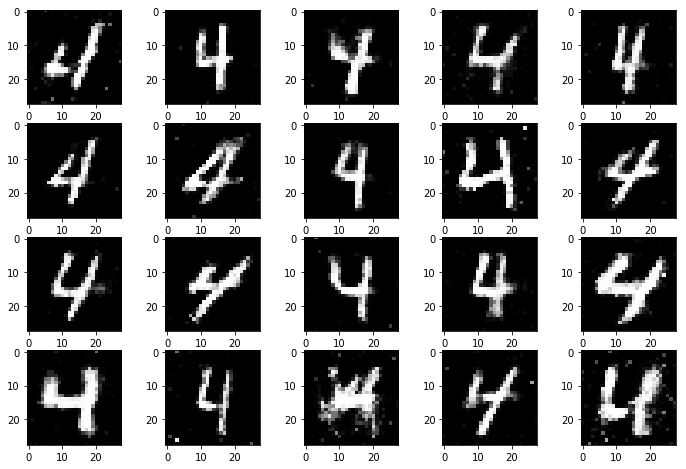

In [13]:
random_img =np.random.randint(0,np.array(l_img).shape[0])
print("Cada vez que se ejecute muestra una imagen aleatoria | epochs= ", random_img*100)
plt.figure(figsize=(12,8))
#lote_img = np.array(l_img)[random_img]
lote_img = np.array(l_img)[-1] 
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(lote_img[i].reshape(28,28), cmap="gray")

In [ ]:
n = 